# Table of Contents
1. [Initial Data Analysis](#Initial-Data-Analysis)
2. [Clustering](#Clustering)
3. [Further Analysis](#Further-Analysis)





In [4]:
import pandas as pd
import scipy.stats as stats
import scipy.stats as sts
from scipy.interpolate import griddata
from torch.nn import functional as F
from helpers import *
import pickle as pkl
from sklearn.cluster import KMeans
import torch.optim as optim
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from datetime import datetime
import seaborn as sns
from torch.utils.data import DataLoader
import torch
from torch import nn
from torch.utils.data import Dataset

import random

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
pd.set_option('display.max_columns', None)

In [5]:
save_dir = ''
precomputed_dir = 'precomputed_data/'
file_names = glob.glob(os.path.join(save_dir, f'QCEH_data/TCV_DATAno*.parquet'))

List of dataframes (one discharge per each element of the list)

In [6]:
df_list = [pd.read_parquet(x) for x in file_names]
len(df_list)

60

# Initial Data Analysis
For this project we are only focusing on the machine inputs provided in the data.

In [7]:
GENERAL_INPUTS = ["shotnumber", "time"]
MACHINE_INPUTS = ["isbaffled", "ip","b0","nel","ptot","pdiv","q95","betan","kappa","deltaavg","deltaupp",
                  "deltalow","gapin","gapout","zmag","rmag","rmin","lpar_ot","zeff"]
LABEL = ["LHD_label"]
INPUTS = GENERAL_INPUTS + MACHINE_INPUTS + LABEL
len(INPUTS)

22

In [8]:
data = pd.concat(df_list, ignore_index=True)[INPUTS]
print(data.shape)
data.head(1)

(624858, 22)


shotnumber  time  isbaffled            ip        b0           nel  \
0     78600.0  0.65        1.0 -168210.37515 -1.442735  3.756246e+19   

            ptot     pdiv       q95     betan    kappa  deltaavg  deltaupp  \
0  175726.540319  0.01331  4.560044  0.732083  1.51264  0.515621   0.34732   

   deltalow     gapin    gapout      zmag      rmag      rmin    lpar_ot  \
0  0.683923  0.027576  0.034128 -0.019449  0.890963  0.224565  15.855245   

       zeff  LHD_label  
0  1.555953        1.0

Before getting deep into the patterns and correlations of our data, we must understand it better.

As such we would like to know if the features are categorical or numerical, what are the ranges of values etc.

### Are the features numerical or categorical?

In [6]:
print("Number of unique values per feature")
data.nunique()

Number of unique values per feature


shotnumber        60
time           23571
isbaffled          2
ip            624858
b0            482384
nel           624858
ptot          624858
pdiv          619035
q95           624858
betan         624858
kappa         624858
deltaavg      624858
deltaupp      624858
deltalow      624852
gapin         623898
gapout        624846
zmag          624858
rmag          624830
rmin          624842
lpar_ot       618063
zeff          593196
LHD_label          3
dtype: int64

The **nunique** functions displays the number of unique values per feature. Looking at these it is safe to say that **shotnumber**, **isbaffled** and **LHD_label** are categorical.

One must still consider that each shot has an assigned unique shotnumber so we will only consider **isbaffled** and **LHD_label** to be **categorical**  and that **all others are numerical features**.

### What ranges do these features take?
Note that we are provided with the intended ranges, so all points outside of these cna be considered to be outliers

In [7]:
print(data["isbaffled"].value_counts())
print(data["LHD_label"].value_counts())

isbaffled
1.0    519828
0.0    105030
Name: count, dtype: int64
LHD_label
3.0    327115
1.0    153237
2.0    144506
Name: count, dtype: int64


We can see that **isbaffled** is a boolean value and is True in about 5/6th of the samples, and that **LHD_label** takes values {1,2,3} which we know to be respectively {L-mode, QCE H-mode and ELMy H-mode}. We can also see that about half of the samples are in state 3 and the other quarters are in 2 and 3.

Now we explore the statistics of the numerical features

In [8]:
data.describe()

shotnumber           time      isbaffled             ip  \
count  624858.000000  624858.000000  624858.000000  624858.000000   
mean    74040.707255       1.180475       0.831914 -171576.191224   
std      5263.061549       0.312433       0.373943    5914.187915   
min     61056.000000       0.650000       0.000000 -208673.029569   
25%     70313.000000       0.910300       1.000000 -172546.928673   
50%     78058.000000       1.173200       1.000000 -171070.907180   
75%     78518.000000       1.447000       1.000000 -168214.796957   
max     78656.000000       1.750000       1.000000 -164599.387828   

                  b0           nel          ptot           pdiv  \
count  624858.000000  6.248580e+05  6.248580e+05  624858.000000   
mean       -1.434432  5.392963e+19  9.334049e+05       0.035056   
std         0.009572  1.575741e+19  3.538534e+05       0.029013   
min        -1.444082  1.581738e+19  7.271428e+04       0.002843   
25%        -1.442735  4.283033e+19  7.772877e+05       0.017190   
50%        -1.441908  5.581423e+19  1.109936e+06       0.027766   
75%        -1.429359  6.460525e+19  1.164649e+06       0.044656   
max        -1.406120  1.021997e+20  1.321485e+06       0.249197   

                 q95          betan          kappa       deltaavg  \
count  624858.000000  624858.000000  624858.000000  624858.000000   
mean        4.599658       1.474483       1.537873       0.466018   
std         0.296005       0.452540       0.060022       0.077521   
min         3.455022       0.292175       1.353821       0.244281   
25%         4.448671       1.248134       1.493217       0.405326   
50%         4.566280       1.624423       1.530225       0.494769   
75%         4.775158       1.780283       1.581193       0.522303   
max         5.786981       2.586815       1.677892       0.613375   

            deltaupp       deltalow          gapin         gapout  \
count  624858.000000  624858.000000  624858.000000  624858.000000   
mean        0.342776       0.589259       0.030130       0.032774   
std         0.127254       0.082856       0.007693       0.007458   
min         0.098603       0.209451       0.000000       0.014442   
25%         0.208675       0.560121       0.025440       0.028233   
50%         0.376676       0.594500       0.030328       0.032672   
75%         0.426111       0.634441       0.034796       0.035909   
max         0.735847       0.727387       0.055782       0.060501   

                zmag           rmag           rmin        lpar_ot  \
count  624858.000000  624858.000000  624858.000000  624858.000000   
mean       -0.009592       0.905936       0.222350      19.276987   
std         0.035352       0.007695       0.005613       7.686711   
min        -0.078045       0.878867       0.201977      12.371704   
25%        -0.030529       0.902355       0.219125      14.564235   
50%        -0.014486       0.908193       0.222103      16.221398   
75%         0.007195       0.911483       0.225884      21.566665   
max         0.173800       0.919038       0.243370      72.994448   

                zeff      LHD_label  
count  624858.000000  624858.000000  
mean        1.983120       2.278268  
std         0.424545       0.831448  
min         1.078659       1.000000  
25%         1.671284       2.000000  
50%         1.925378       3.000000  
75%         2.201146       3.000000  
max         3.319004       3.000000

This description is interesting as it reflects the diversity of our data. Indeed, some of the features such as **b0** are negative while others like **nel** are positive and orders of magnitude larger.

This analysis reflects the importance of standardization. We will go for 0 means and unit variance.

Now we are particularly interested in the ranges of values of our features.

In [9]:
data_actual_min_max = pd.concat([data.min(axis = 0).rename("min"), data.max(axis = 0).rename("max")], axis = 1)

With the data, we are provided a range of values which these features should take. All points outside of these ranges can be considered to be outliers. 

### Detecting outliers

In [10]:
normal_feature_ranges = {"shotnumber":(61056, 78656), "time":(0.650,1.800), "isbaffled":(0,1), "ip":(-5*10**5,5*10**5),"b0":(-2,2),"nel":(10**18,5*10**20),"ptot":(10**4,3*10**6),"pdiv":(0,5*10**-1),"q95":(3,6),"betan":(0,3),"kappa":(1,2),"deltaavg":(0,1),"deltaupp":(0,1),
                  "deltalow":(0,1),"gapin":(0,0.1),"gapout":(0,0.1),"zmag":(-0.2,0.2),"rmag":(0.85,0.95),"rmin":(0.2,0.3),"lpar_ot":(0,100),"zeff":(1,5),"LHD_label":(1,3)}
df_normal_feature_ranges = pd.DataFrame(normal_feature_ranges, ["reasonable_min", "reasonable_max"]).T

data_min_max = pd.concat([data_actual_min_max, df_normal_feature_ranges], axis = 1)
data_min_max

min           max       reasonable_min  \
shotnumber  6.105600e+04  7.865600e+04                61056   
time        6.500000e-01  1.750000e+00                 0.65   
isbaffled   0.000000e+00  1.000000e+00                    0   
ip         -2.086730e+05 -1.645994e+05              -500000   
b0         -1.444082e+00 -1.406120e+00                   -2   
nel         1.581738e+19  1.021997e+20  1000000000000000000   
ptot        7.271428e+04  1.321485e+06                10000   
pdiv        2.842617e-03  2.491965e-01                  0.0   
q95         3.455022e+00  5.786981e+00                    3   
betan       2.921755e-01  2.586815e+00                    0   
kappa       1.353821e+00  1.677892e+00                    1   
deltaavg    2.442810e-01  6.133749e-01                    0   
deltaupp    9.860258e-02  7.358472e-01                    0   
deltalow    2.094509e-01  7.273875e-01                    0   
gapin       0.000000e+00  5.578166e-02                  0.0   
gapout      1.444223e-02  6.050084e-02                  0.0   
zmag       -7.804539e-02  1.738004e-01                 -0.2   
rmag        8.788669e-01  9.190382e-01                 0.85   
rmin        2.019767e-01  2.433696e-01                  0.2   
lpar_ot     1.237170e+01  7.299445e+01                    0   
zeff        1.078659e+00  3.319004e+00                    1   
LHD_label   1.000000e+00  3.000000e+00                    1   

                   reasonable_max  
shotnumber                  78656  
time                          1.8  
isbaffled                       1  
ip                         500000  
b0                              2  
nel         500000000000000000000  
ptot                      3000000  
pdiv                          0.5  
q95                             6  
betan                           3  
kappa                           2  
deltaavg                        1  
deltaupp                        1  
deltalow                        1  
gapin                         0.1  
gapout                        0.1  
zmag                          0.2  
rmag                         0.95  
rmin                          0.3  
lpar_ot                       100  
zeff                            5  
LHD_label                       3

Now we can see which of these features go over the range of reasonable feature values

In [11]:
pd.concat([(data_min_max["min"] < data_min_max["reasonable_min"]).rename("has_underflow"), (data_min_max["max"] > data_min_max["reasonable_max"]).rename("has_overflow")], axis = 1)

has_underflow  has_overflow
shotnumber          False         False
time                False         False
isbaffled           False         False
ip                  False         False
b0                  False         False
nel                 False         False
ptot                False         False
pdiv                False         False
q95                 False         False
betan               False         False
kappa               False         False
deltaavg            False         False
deltaupp            False         False
deltalow            False         False
gapin               False         False
gapout              False         False
zmag                False         False
rmag                False         False
rmin                False         False
lpar_ot             False         False
zeff                False         False
LHD_label           False         False

None of the features underflow or overflow, as such we can conclude that we have no outliers! We may procede with our analysis while considering all data points.



### Are the shot numbers similar?

In [12]:
shotnumbers = list(set(data["shotnumber"]))
shotnumbers.sort()
shotnumbers

[61056.0,
 61057.0,
 64438.0,
 64467.0,
 64469.0,
 64495.0,
 64950.0,
 66166.0,
 66169.0,
 70302.0,
 70305.0,
 70306.0,
 70310.0,
 70311.0,
 70313.0,
 70654.0,
 70656.0,
 70657.0,
 71344.0,
 71345.0,
 71351.0,
 73532.0,
 73784.0,
 73785.0,
 73786.0,
 73838.0,
 73846.0,
 75461.0,
 75464.0,
 78058.0,
 78061.0,
 78064.0,
 78069.0,
 78089.0,
 78090.0,
 78091.0,
 78104.0,
 78260.0,
 78261.0,
 78262.0,
 78368.0,
 78382.0,
 78510.0,
 78512.0,
 78518.0,
 78521.0,
 78524.0,
 78597.0,
 78598.0,
 78600.0,
 78601.0,
 78602.0,
 78603.0,
 78604.0,
 78606.0,
 78608.0,
 78611.0,
 78637.0,
 78639.0,
 78656.0]

Looking at these shot numbers, we can see that some of them are back to back. As such we could imagine that these experiments were in batches. This will be interesting in our analyses, because we might have batches of similar shots with a few tweaks in the parameters. In that case, it will be interesting to compare the results of similar shots to see what small changes may yield better or worst results.

# Now we Visualize

In [13]:
# This normalizes the X values.
X, y, column_names = get_training_data(include_time = False, include_shotnumber = False, shot_indices = list(range(5)))
column_names

['isbaffled',
 'ip',
 'b0',
 'nel',
 'ptot',
 'pdiv',
 'q95',
 'betan',
 'kappa',
 'deltaavg',
 'deltaupp',
 'deltalow',
 'gapin',
 'gapout',
 'zmag',
 'rmag',
 'rmin',
 'lpar_ot',
 'zeff',
 'LHD_label']

In [14]:
X.shape

(55005, 19)

In [15]:
# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X)

In [16]:
# Print scaled eigenvalues of principal components
print("Percentage of variance of Principal Components:")
print(100 * pca.explained_variance_ / pca.explained_variance_.sum())

Percentage of variance of Principal Components:
[4.42995016e+01 2.62499814e+01 1.24292069e+01 7.03102268e+00
 3.74274644e+00 1.87852962e+00 1.82242849e+00 9.43667404e-01
 4.93019790e-01 4.30619447e-01 3.57177638e-01 1.99344005e-01
 6.90040638e-02 3.27137923e-02 1.22962298e-02 7.20669304e-03
 1.53390922e-03 3.01896321e-15 0.00000000e+00]


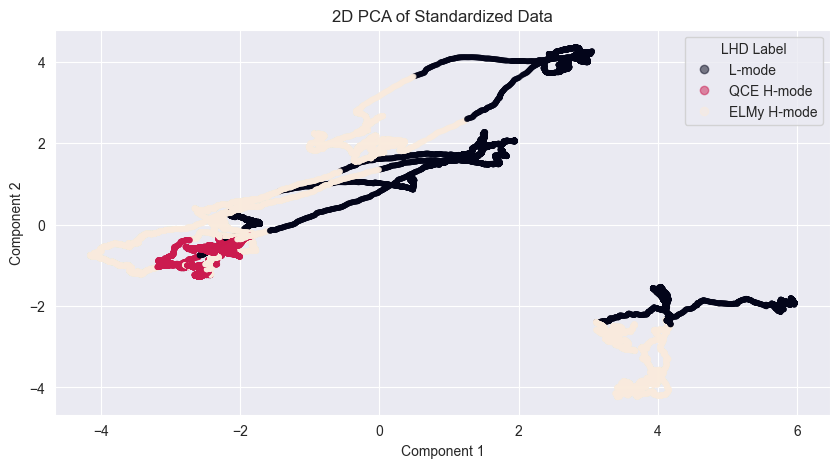

In [17]:
draw_reduced_space(X_pca[:, :2], y, n_components = 2, title = "2D PCA of Standardized Data")

# How about 3D

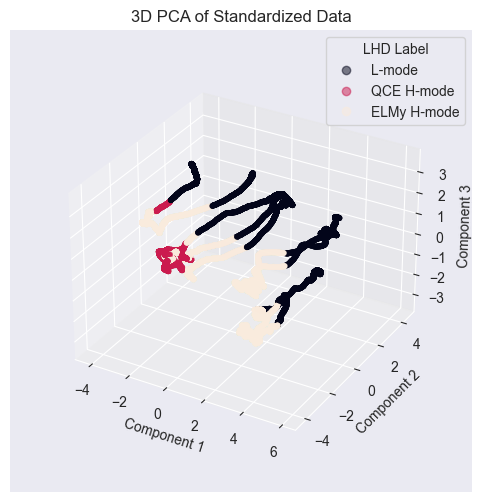

In [18]:
draw_reduced_space(X_pca[:, :3], y, n_components = 3, title = "3D PCA of Standardized Data")

# Analysis
Looking at the PCA for a single shot, we can see that the scatter plots follow a somewhat continuous path. As such we can expect Clustering Algorithms like DBSCAN to perform better than for instance K-means (which favor clusters that are spherical and not complex shapes of dense neighborhoods of points)

When considering 5 shots, we can already see that the scatter plots start overlapping; however, there are two clearly distinct clusters appearing. The initial hypothesis is that this change comes from the is_baffled state; however, this will need to be checked.

# Visualizing data, looking for patterns or clusters
TSNE is a more traditional approach to dimentionality reduction that somewhat maintains clusters 
It is very costly for high dimensionality datasets and UMAP solves that issue

As stated by the UMAP doc:

**n_neighbors**: This determines the number of neighboring points used in local approximations. Larger values will result in more global structure being preserved at the loss of detailed local structure. In general this parameter should often be in the range 5 to 50, with a choice of 10 to 15 being a sensible default.

**min_dist**: This controls how tightly the embedding is allowed compress points together. Larger values ensure embedded points are more evenly distributed, while smaller values allow the algorithm to optimise more accurately with regard to local structure. Sensible values are in the range 0.001 to 0.5, with 0.1 being a reasonable default.
Smaller min_distances are better for clustering
From there we try different UMAP settings

**n_components** parameter option that allows the user to determine the dimensionality of the reduced dimension space we will be embedding the data into.

/Users/ericsaikali/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/tokamak-unsupervised/venv/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


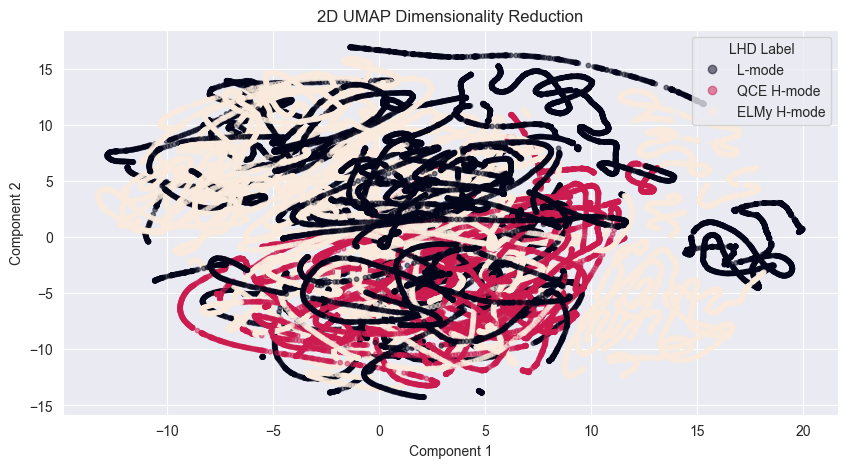

In [19]:
X_umap = perform_umap(X, n_components=2)[1]
draw_reduced_space(X_umap, y, n_components=2, title='2D UMAP Dimensionality Reduction')


Of course we can also plot a third component to get an even better view of the dimensionality reduction!

/Users/ericsaikali/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/tokamak-unsupervised/venv/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


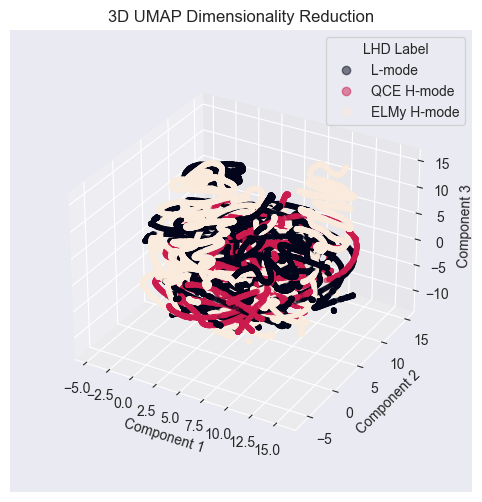

In [20]:
draw_reduced_space(perform_umap(X,  n_components=3)[1], y, n_components=3, title='3D UMAP Dimensionality Reduction')

Let's see now if we can detect some patterns between all the shots :
As standard practice, we will revert to PCA for now.

In [21]:
complete_X, complete_y, column_names = get_training_data(include_time = False, include_shotnumber = False, shot_indices = list(range(60)))
X_pca = perform_pca(complete_X, n_components=2)

In [22]:
# we build a dataframe with the two main components and the label as columns
df_2_components = pd.DataFrame(
    data=X_pca[:,:2], 
    columns=['Component1', 'Component2']) 

target_names = {
    1:'L-mode',
    2:'QCE H-mode', 
    3:'ELMy H-mode'
}
df_2_components['LHD label'] = complete_y
df_2_components['LHD label'] = df_2_components['LHD label'].map(target_names)

In [23]:
df_2_components

Component1  Component2 LHD label
0         1.698785    1.597856    L-mode
1         1.698836    1.597745    L-mode
2         1.698889    1.597633    L-mode
3         1.698943    1.597519    L-mode
4         1.698998    1.597404    L-mode
...            ...         ...       ...
624853   -2.327065    1.183210    L-mode
624854   -2.328844    1.183456    L-mode
624855   -2.330625    1.183702    L-mode
624856   -2.332320    1.183980    L-mode
624857   -2.333966    1.184281    L-mode

[624858 rows x 3 columns]

# Heatmap of Label density in reduced space
Heatmaps help us see in which points of space a label is more likely to be present.

Of course, these visualizations don't take time into account; however, they still reveal that certain zones are more correlated with some LHD labels.

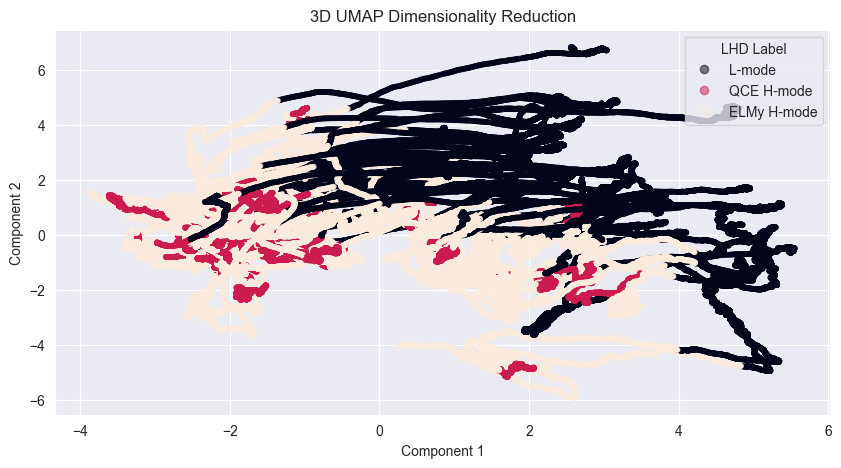

In [24]:
draw_reduced_space(X_pca, complete_y, n_components=2, title='3D UMAP Dimensionality Reduction')


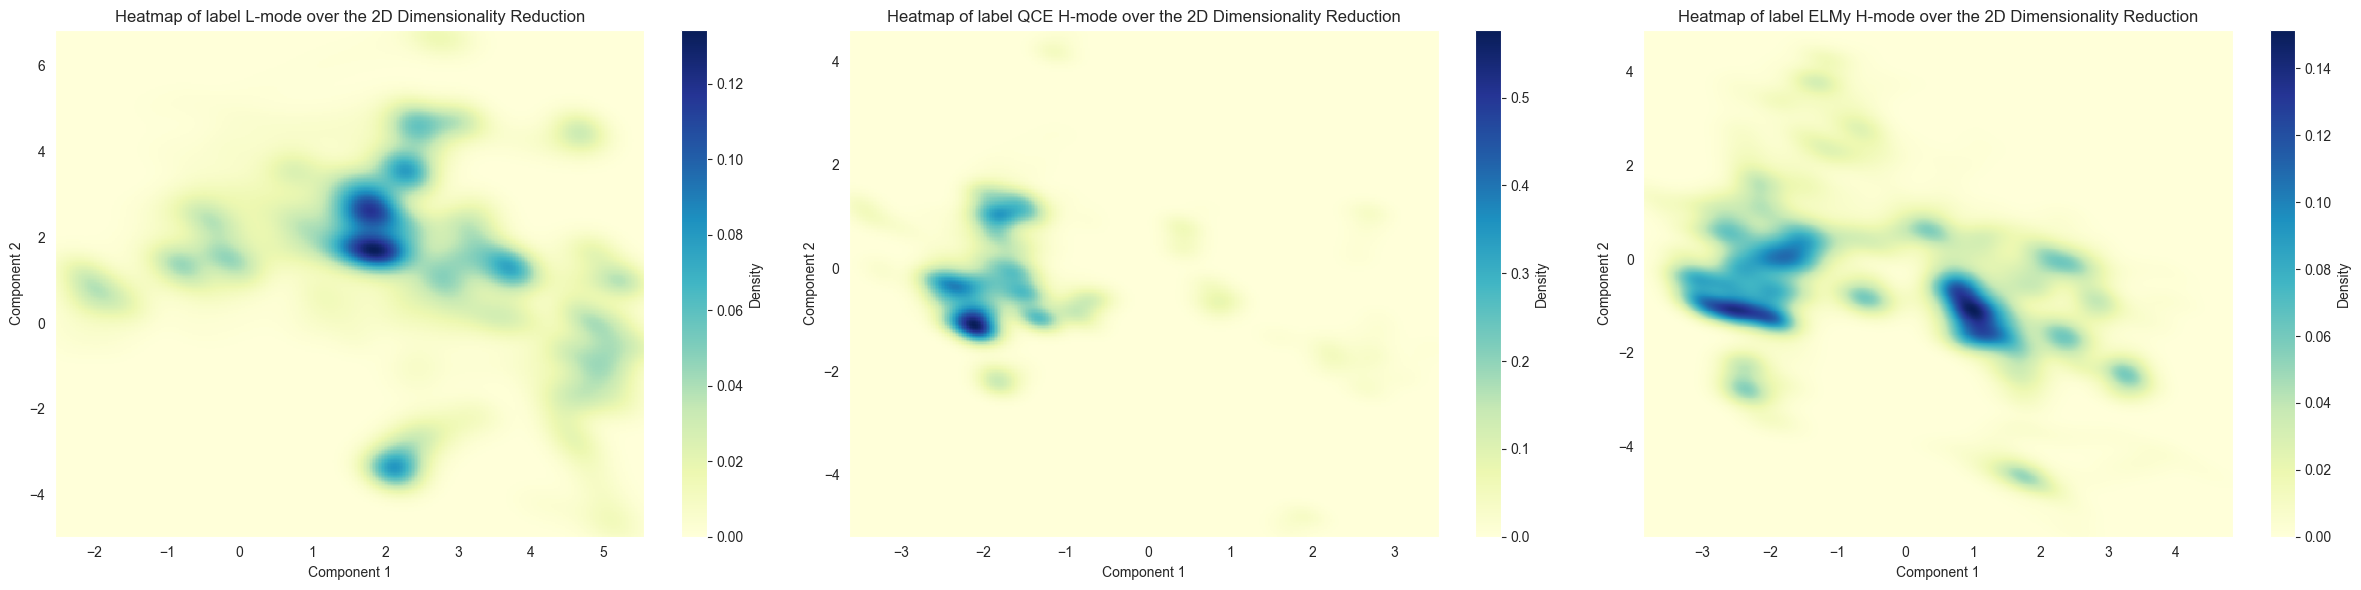

In [25]:
num_labels = len(target_names.values())

fig, axes = plt.subplots(1, num_labels, figsize=(8 * num_labels, 6))

top_5_percent_indices = {}

for i, label in enumerate(target_names.values()):
    # Select data for the current label
    data = df_2_components[df_2_components['LHD label'] == label]
    pltx = data['Component1']
    plty = data['Component2']

    # Estimate the density
    k = sts.gaussian_kde([pltx, plty])
    xi, yi = np.mgrid[pltx.min():pltx.max():pltx.size**0.5*1j, plty.min():plty.max():plty.size**0.5*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    # Plotting the density on the ith subplot
    ax = axes[i]
    pcm = ax.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap=plt.cm.YlGnBu)
    fig.colorbar(pcm, ax=ax, label='Density')
    ax.set_title(f'Heatmap of label {label} over the 2D Dimensionality Reduction')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')

    # Find the threshold for the top 5%
    threshold = np.percentile(zi, 95)

    # Retrieve the indices of points above this threshold
    points_above_threshold = zi > threshold
    interpolated_points = griddata((xi.flatten(), yi.flatten()), points_above_threshold, (pltx, plty), method='nearest')
    top_5_percent_indices[label] = data[interpolated_points].index

plt.tight_layout()
plt.show()

Let's now invert the mapping and retrieve the features of the "hotspot" or agglomeration of samples displayed by each of the heatmaps

In [26]:
qce_h_top_5_percent = pd.DataFrame(complete_X[top_5_percent_indices['QCE H-mode']], columns=column_names[:-1])
l_mode_top_5_percent = pd.DataFrame(complete_X[top_5_percent_indices['L-mode']], columns=column_names[:-1])
elmy_h_mode_top_5_percent = pd.DataFrame(complete_X[top_5_percent_indices['ELMy H-mode']], columns=column_names[:-1])

In [27]:
p_value_threshold = 0.05
qce_h_vs_l_mode_significance = []
qce_h_vs_elmy_significance = []
for feature in column_names[:-1]:
    # QCE H-mode vs L-mode
    _, p_value_qce_l = sts.mannwhitneyu(qce_h_top_5_percent[feature], l_mode_top_5_percent[feature])
    
    # QCE H-mode vs Elmy H-mode
    _, p_value_qce_elmy = sts.mannwhitneyu(qce_h_top_5_percent[feature], elmy_h_mode_top_5_percent[feature])
    
    if p_value_qce_l < p_value_threshold:
        qce_h_vs_l_mode_significance.append(feature)
    if p_value_qce_elmy < p_value_threshold:
        qce_h_vs_elmy_significance.append(feature)
        
print(f"Between QCE H-mode and L-mode: Mann-Whitney U Test displays a statistical difference at 95% confidence for {len(qce_h_vs_l_mode_significance)} features: {qce_h_vs_l_mode_significance} \n")
print(f"Between QCE H-mode and ELMy H-mode: Mann-Whitney U Test displays a statistical difference at 95% confidence for {len(qce_h_vs_elmy_significance)} features: {qce_h_vs_elmy_significance}")

Between QCE H-mode and L-mode: Mann-Whitney U Test displays a statistical difference at 95% confidence for 19 features: ['isbaffled', 'ip', 'b0', 'nel', 'ptot', 'pdiv', 'q95', 'betan', 'kappa', 'deltaavg', 'deltaupp', 'deltalow', 'gapin', 'gapout', 'zmag', 'rmag', 'rmin', 'lpar_ot', 'zeff'] 

Between QCE H-mode and ELMy H-mode: Mann-Whitney U Test displays a statistical difference at 95% confidence for 19 features: ['isbaffled', 'ip', 'b0', 'nel', 'ptot', 'pdiv', 'q95', 'betan', 'kappa', 'deltaavg', 'deltaupp', 'deltalow', 'gapin', 'gapout', 'zmag', 'rmag', 'rmin', 'lpar_ot', 'zeff']


In [28]:
print('Mean values for the QCE-H state "hotspot" :')
display(qce_h_top_5_percent.mean())

Mean values for the QCE-H state "hotspot" :


isbaffled    0.449497
ip           0.106144
b0          -0.425824
nel          0.653457
ptot         0.623948
pdiv         0.174714
q95          0.145322
betan        0.435120
kappa       -0.189214
deltaavg     0.754903
deltaupp     0.627387
deltalow     0.449025
gapin        0.381497
gapout      -0.031721
zmag        -0.694062
rmag         0.496306
rmin        -0.351068
lpar_ot     -0.315628
zeff         0.482267
dtype: float64

## Initial Analysis - Conclusion
With these heatmaps we take every timestep as "independent" without considering the previous steps in the shot. Even if they allow to find values that indicate the desired state, the interpretability of these values is quite limited since independency here is a strong assumption.

In our next analyses we would like to consider the "history" of a shot.

Indeed, what we are really interested is how and how long it took for a shot to reach a certain point in space. In addition, we want to know how the label evolved as the timeseries happens.

To get answers to these questions we will have to consider time!

In [29]:
qce_h_mean = qce_h_top_5_percent.mean()
l_mode_mean = l_mode_top_5_percent.mean()
elmy_h_mode_mean = elmy_h_mode_top_5_percent.mean()
hotspots_mean = pd.concat([qce_h_mean, l_mode_mean, elmy_h_mode_mean], axis=1).T
hotspots_mean['Mode'] = ["QCE-H mode", "L-mode", "ELMy-H mode"]
hotspots_mean.to_csv('hotspots_mean.csv', index=False)

### Key takaways :
**data is continuous** : As such we can expect Clustering Algorithms like DBSCAN to work well

**UMAP is ideal** : It allows dimensionality reduction while maintaining clusters 

**need for shot history** : we interested is how and how long it took for a shot to reach a certain point




# Clustering

## DBSCAN

### Generate a range of values for eps 

Hyperparameter tuning is essential

We need to choose the MinPts (the min number of points per cluster), and eps the radius for neighborhood computation.

MinPts: 
In practice, a general rule of thumb is that the min cluster size is equal to 2 * #features; however it can be higher for noisy data.

eps:
The value for epsilon can be chosen using a k-distance graph, which consists in plotting the distance to the k = minPts-1 nearest neighbors (ordered)
Good values of ε are where this plot shows an "elbow"
Another way to select the epsilon is to use the silouhette score, this is what we are doing here:

In [30]:
num_features = len(column_names)
eps_values = np.linspace(0.1, 4.0, 10) #DBSCAN takes much more time for higher eps
min_pts = 2 * num_features

In [31]:
# Initialize variables to store results
best_eps = None
best_silhouette_score = -1  # Initialize with a value less than any possible silhouette score


Computing the silhouette score is quite expensive as it involves the computation of the euclidean distance between all pairs in X. (~360 min)
Also note that DBSCAN time complexity increases very quickly as eps increases.

A possible solution is to only compute this matrix once; however, if X has N samples then the distance matrix has N^2 samples which is too large for N >= 50 000

Since we have 60 shots, taking half of them is representative enough for our dataset and reduces overfitting. (would take ~90 min) but how to select a shot ?

Another solution would be to iterate through range of L shots (L per L) and then aggregate the silhouette value per epsilon to find the optimal epsilon according to the aggregated values.
This approach allow for speed efficiency, all shots consideration and avoids overfitting.

we select `L=10` as a range to enable fast computation yet generalized enough.


A custom made technique :
## L-fold Hyperparameter tuning

In [32]:
L = 10
N_SHOTS = 60
# the training data fetched is already standardized.
X_standardized_list = [
    get_training_data(
        include_time=False,
        include_shotnumber=False,
        shot_indices=list(range(i * L , i * L  + L))
    )[0] for i in range(N_SHOTS // L)
]


In [33]:
X_standardized_list[0].shape

(108670, 19)

In [34]:
# Initialize matrix to store silhouette scores
silhouette_scores = np.zeros((N_SHOTS//L,len(eps_values)))
silhouette_scores.shape

(6, 10)

In [35]:
# For simplicity of running the jupyter quickly, try loading precomputed desired silhouette scores.

try:
    with open(f"{precomputed_dir}silhouette_scores_for_{L}_per_{L}.pkl", 'rb') as f:
        silhouette_scores = pkl.load(f)
# If the desired silhouette scores does not exist, compute it.
except:
    dbscan = DBSCAN()
    # Loop over different combinations of eps and min_samples
    for j, X_standardized in tqdm(enumerate(X_standardized_list), total=N_SHOTS // L):
        for i, eps in tqdm(enumerate(eps_values), total=len(eps_values)):
            # Fit DBSCAN with current parameters
            start = datetime.now()
            dbscan = dbscan.set_params(eps=eps, min_samples=min_pts)# DBSCAN(eps=eps, min_samples=min_pts)
            labels = dbscan.fit_predict(X_standardized)
            print("DBSCAN ", datetime.now()-start)
            
            # Calculate silhouette score
            start = datetime.now()
            try:
                silhouette = silhouette_score(X_standardized, labels)
            except:
                silhouette = 0
            print("Silhouette ", datetime.now()-start)
            silhouette_scores[j, i] = silhouette  
            # Store the silhouette score
                
            # Update the best parameters if the silhouette score is higher
            if silhouette > best_silhouette_score:
                best_silhouette_score = silhouette
                best_min_pts = min_pts
                best_eps = eps
        
    # Print the best parameters
    print(f"Best eps: {best_eps}")
    print(f"Best silhouette score: {best_silhouette_score}")
    with open(f'{precomputed_dir}silhouette_scores_for{L}_per_{L}.pkl', 'wb') as f:
        pkl.dump(silhouette_scores, f)


In [36]:
aggregated_silhouette_scores_mean = np.mean(silhouette_scores, axis=0)
aggregated_silhouette_scores_median = np.median(silhouette_scores, axis=0)
aggregated_silhouette_scores_median.shape

(10,)

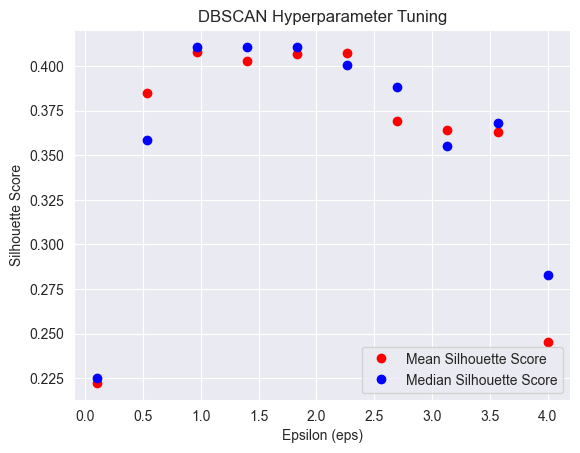

In [37]:
plt.plot(eps_values, aggregated_silhouette_scores_mean, "ro", label="Mean Silhouette Score")
plt.plot(eps_values, aggregated_silhouette_scores_median, "bo", label="Median Silhouette Score")
plt.title(f"DBSCAN Hyperparameter Tuning")
plt.xlabel("Epsilon (eps)")
plt.ylabel("Silhouette Score")
plt.legend()


In [38]:
best_mean_eps = eps_values[np.argmax(aggregated_silhouette_scores_mean)]
best_median_eps = eps_values[np.argmax(aggregated_silhouette_scores_median)]
print("best mean eps :", best_mean_eps)
print("best median eps :", best_median_eps)

best mean eps : 0.9666666666666667
best median eps : 0.9666666666666667


Ideally, we want an epsilon that yields the highest silhouette score; however, we want epsilon to be small too. So here we take the smallest epsilon which yields a high silhouette score. Here we are lucky ! since both highest silhouette with the smallest epsilon is the same, furthermore the median and mean are in accordance here. 

Theoretically everything says that we should take `eps = 0.966`.

Upon running the next cells with this epsilon value we get the expected results of similar paths.


In [39]:
selected_eps = 0.96
selected_min_pts = num_features * 2 

Let's now compute DBSCAN for 5 shots :

In [40]:
# This normalizes the X values.
X, y, column_names = get_training_data(include_time = False, include_shotnumber = False, shot_indices = list(range(5)))
X.shape

(55005, 19)

In [41]:
dbscan = DBSCAN(eps=selected_eps, min_samples=selected_min_pts).fit(X)

labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 4
Estimated number of noise points: 0


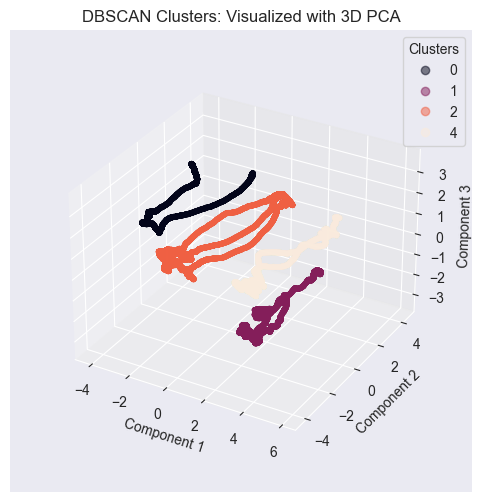

In [42]:
pca = PCA()
X_pca = pca.fit_transform(X)
draw_reduced_space(X_pca[:, :3], labels, n_components = 3, legend_labels = [0,1,2, 4, 5], legend_title ="Clusters", title = "DBSCAN Clusters: Visualized with 3D PCA")

## Analysis

Thanks to the silhouette score computation, we can say that the aggregated optimal epsilon `eps` for DBscan is theoretically `0.96`
Through these computations, we can therefore compute better DBSCAN on our data.
The above visualization and the one in the first analysis, displayed that similar shots could be regrouped and conversely separated from different ones.

This separation could allow us to regroup similar shots for further and closer inspection.

In order to enhance these agglomerations in clusters.


## DBSCAN
Using the optimal values yielded by the L-fold above, we can now use the DBSCAN on the hole data set.

Let's now retrieve the entire dataset :

In [43]:
complete_X, complete_y, _  = get_training_data(include_time=False, 
                                           include_shotnumber=False,
                                           shot_indices=list(range(60))
                                           )

In [44]:
label_filename = f'{precomputed_dir}labels_dbscan_eps_{selected_eps}_min_pts_{selected_min_pts}.pkl'
dbscan_fitted_filename = f'{precomputed_dir}fit_dbscan_eps_{selected_eps}_min_pts_{selected_min_pts}.pkl'

try:
    with open(label_filename, 'rb') as f:
        labels = pkl.load(f)
    with open(dbscan_fitted_filename, 'rb') as f:
        dbscan = pkl.load(f)
except:
    dbscan = DBSCAN(eps=selected_eps, min_samples=selected_min_pts).fit(complete_X)
    labels = dbscan.labels_
    with open(label_filename, 'wb') as f:
        pkl.dump(labels,f)
    with open(dbscan_fitted_filename, 'wb') as f:
        pkl.dump(dbscan,f)

In [45]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 29
Estimated number of noise points: 0


**Let's now visualize what the DBSCAN gave us using PCA**

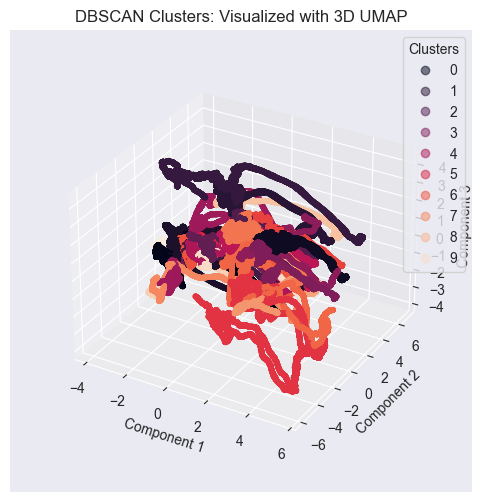

In [46]:
pca = PCA()
X_pca = pca.fit_transform(complete_X)

draw_reduced_space(X_pca[:, :3], labels, n_components = 3, legend_labels = range(n_clusters_), legend_title ="Clusters", title = "DBSCAN Clusters: Visualized with 3D PCA")

The graph seems unclear, in order to evaluate it let's look at each cluster separately:

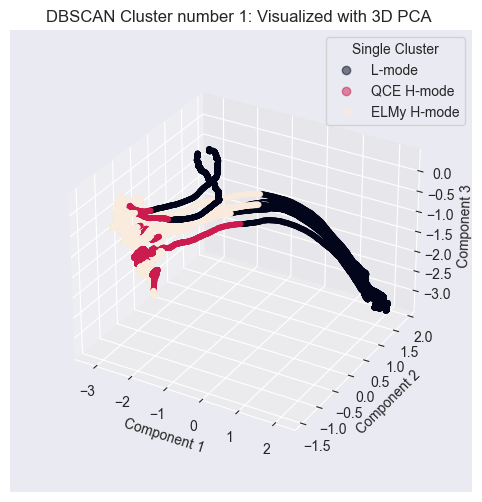

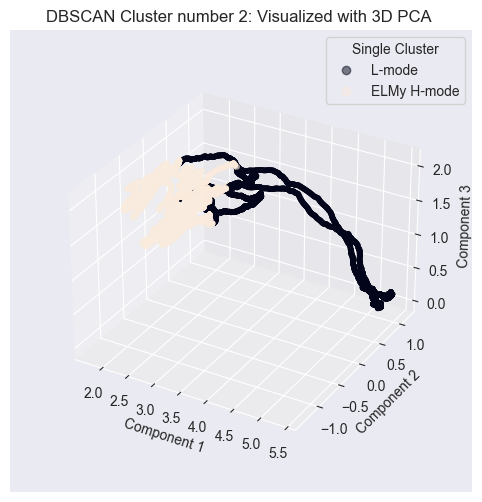

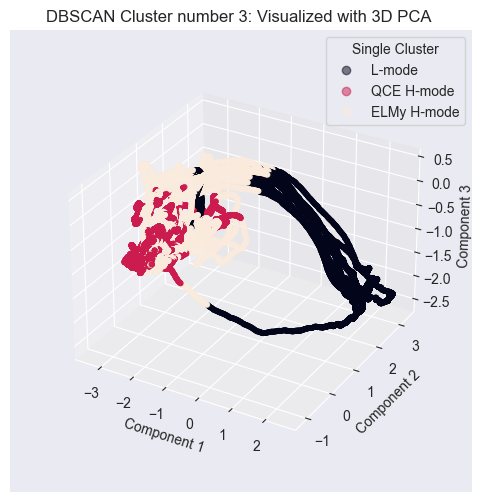

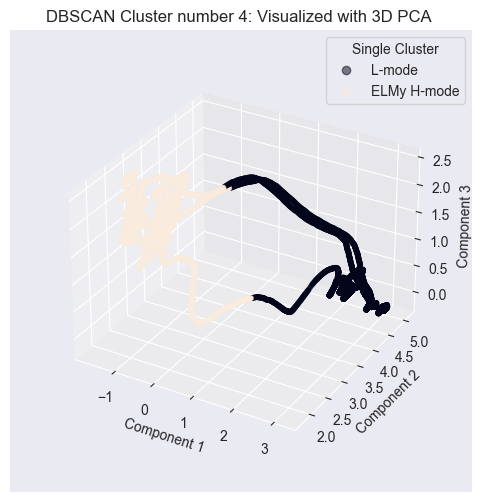

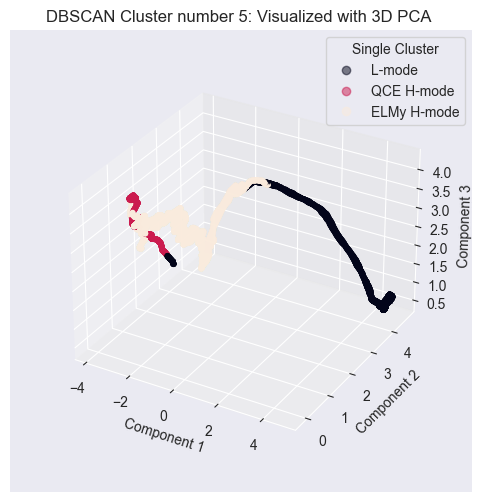

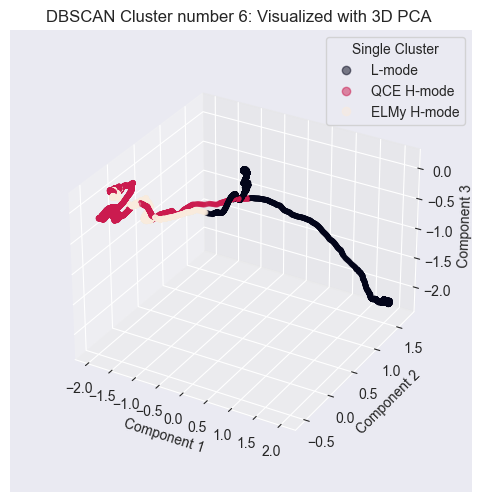

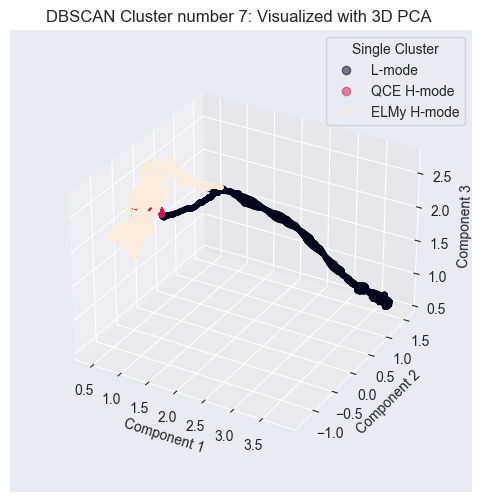

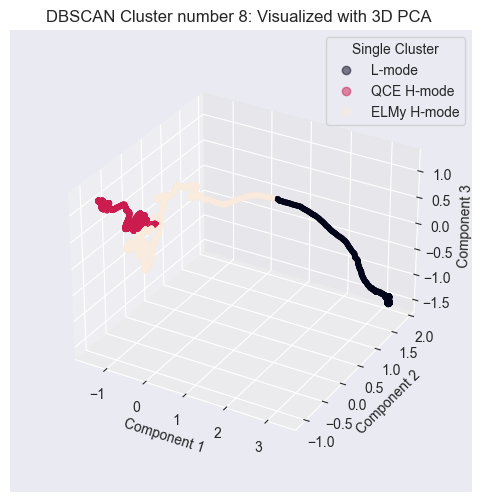

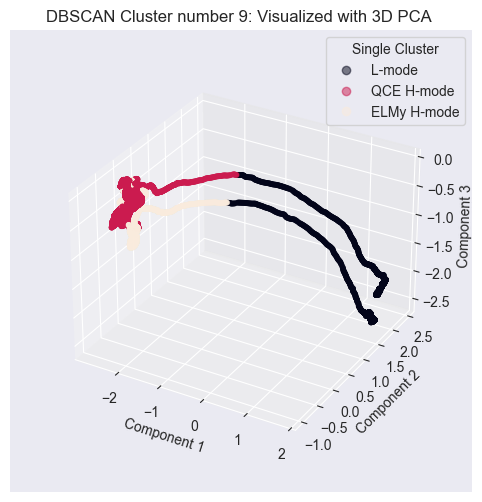

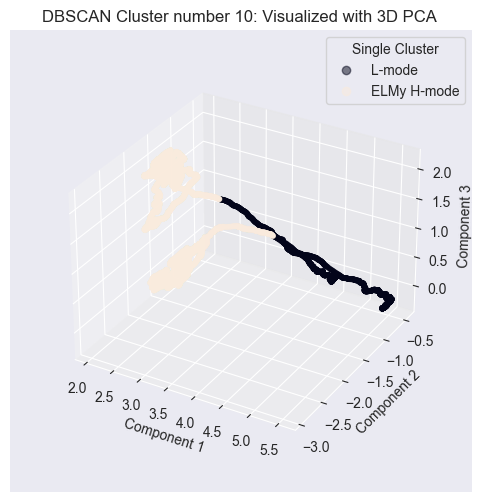

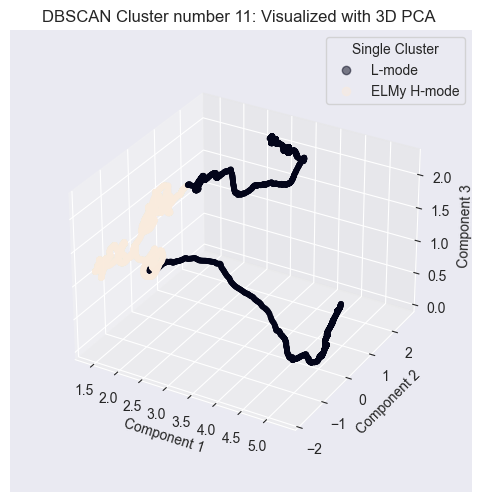

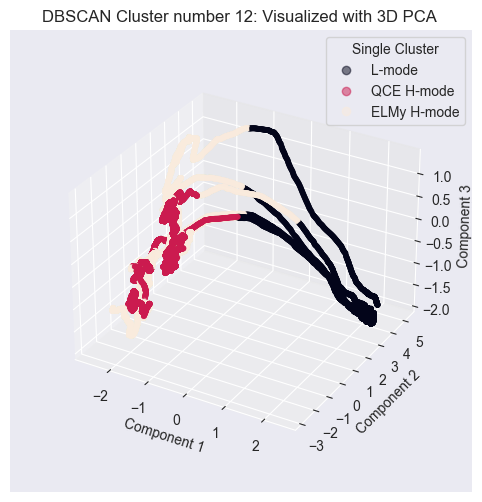

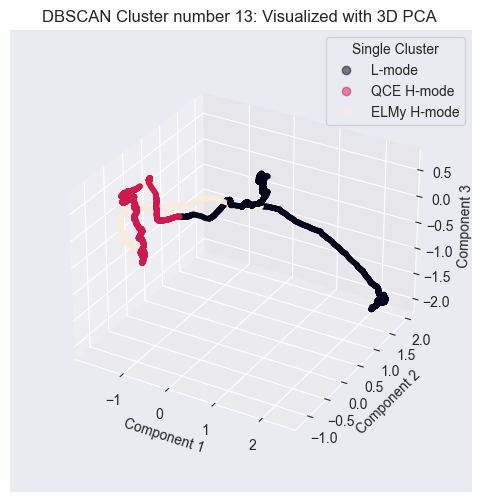

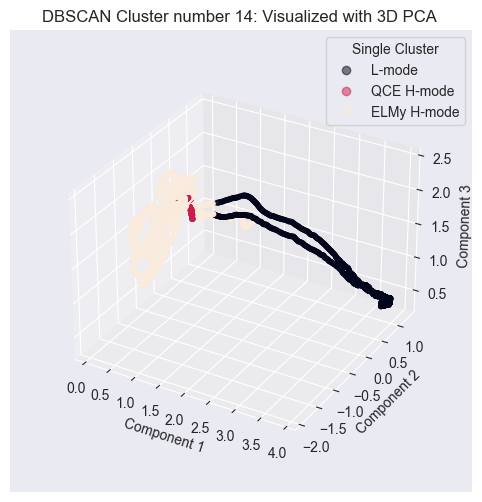

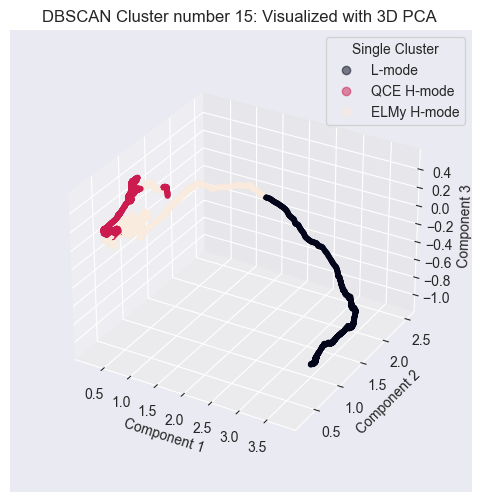

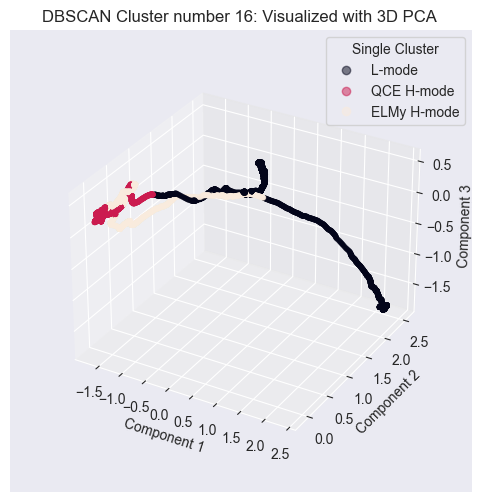

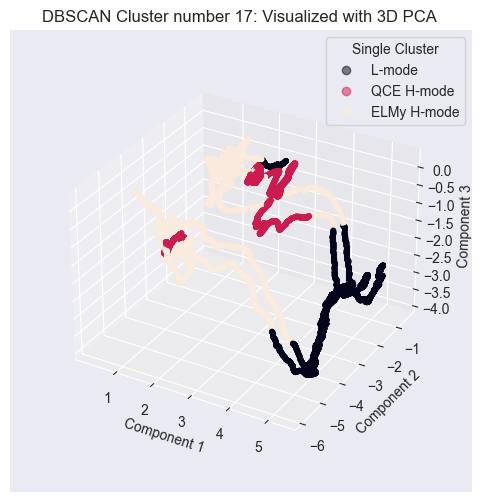

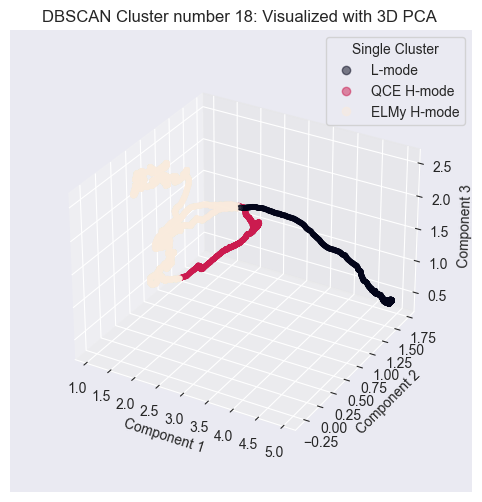

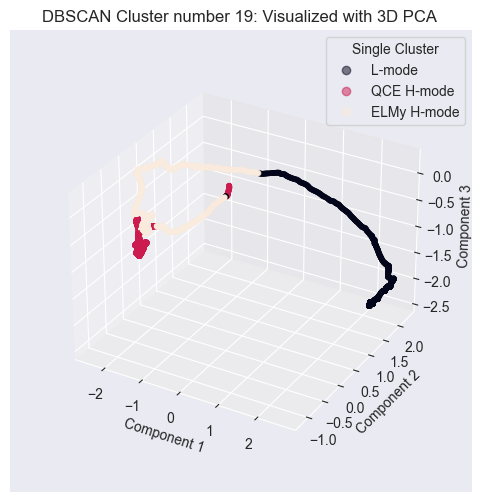

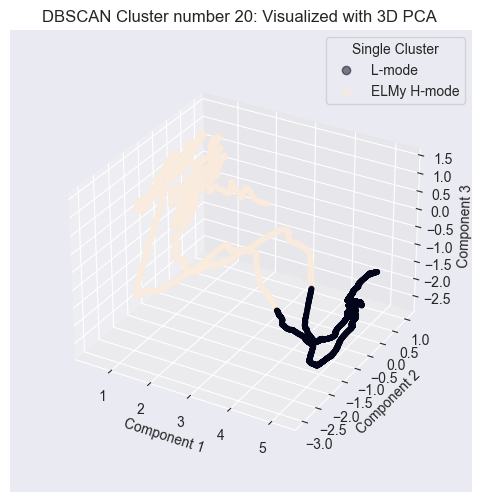

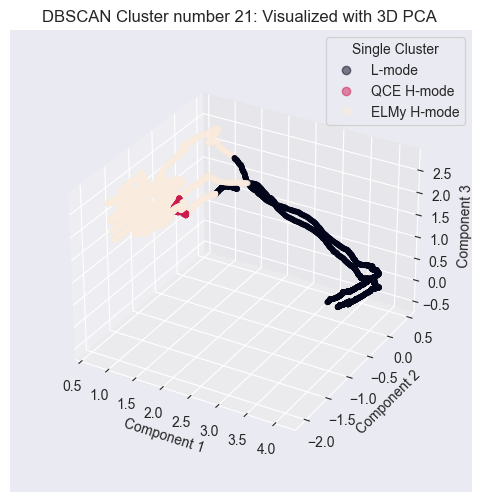

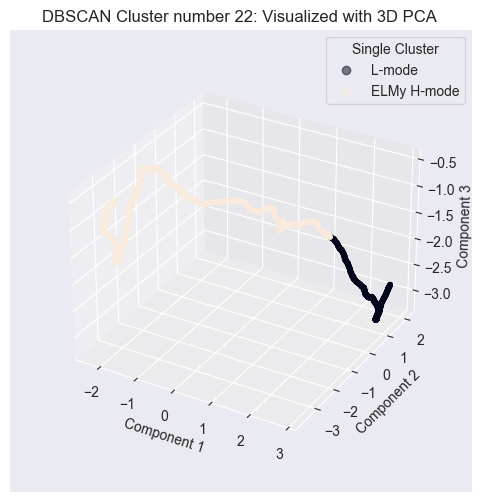

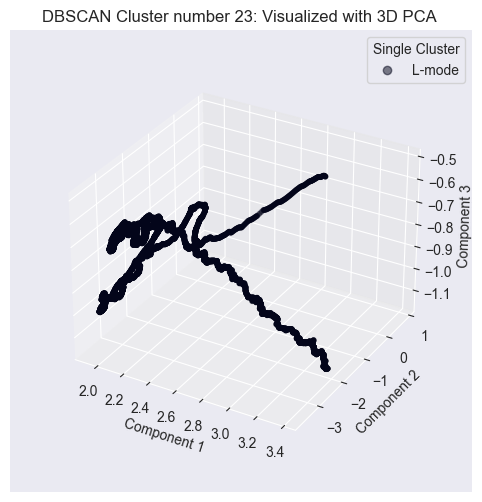

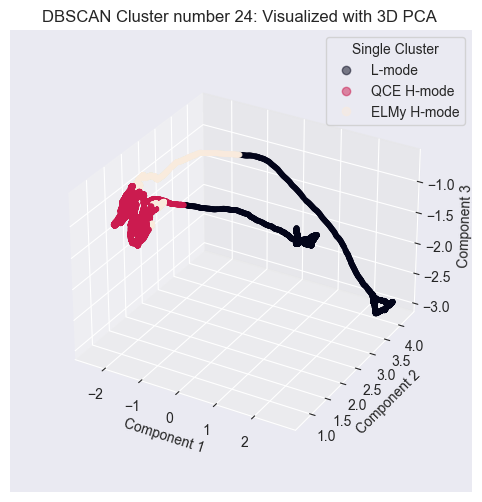

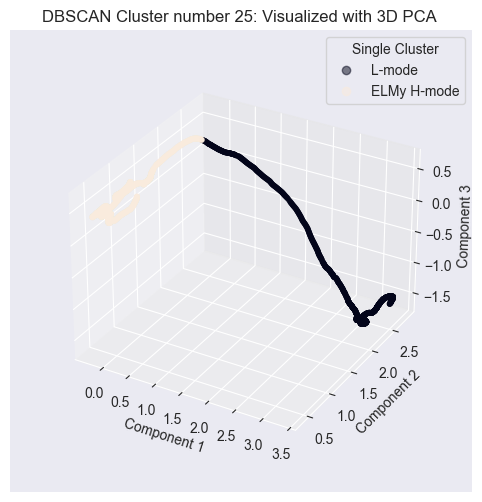

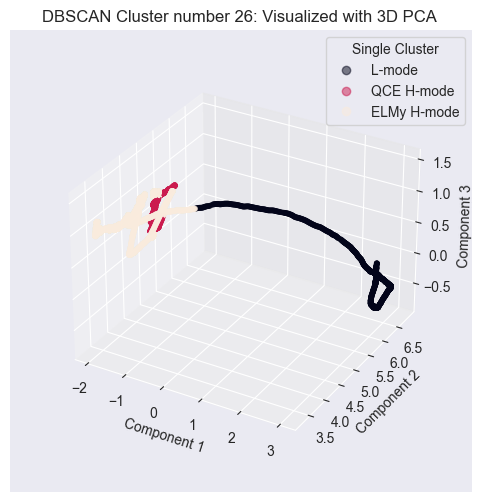

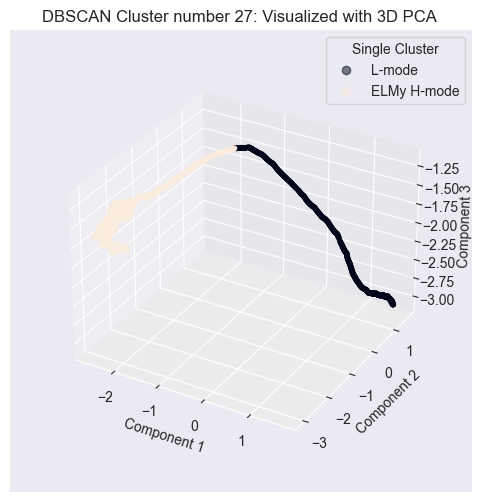

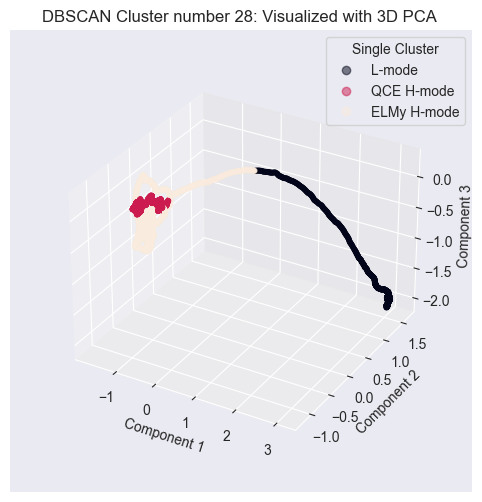

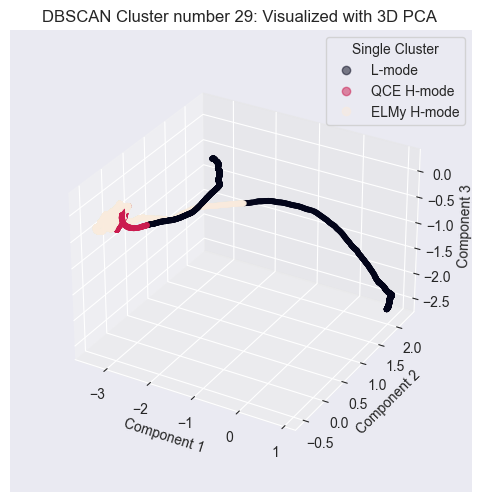

In [47]:
# Create a 3D UMAP plot for each cluster
cluster_idxs = []
for cluster_label in range(n_clusters_):
    # Filter data points belonging to the current cluster
    cluster_indices = np.where(labels == cluster_label)[0]
    cluster_idxs.append(cluster_indices)
    cluster_data = X_pca[cluster_indices]
    cluster_true_label = complete_y[cluster_indices]
    draw_reduced_space(cluster_data[:, :3], cluster_true_label, n_components = 3, legend_title ="Single Cluster", title = f"DBSCAN Cluster number {cluster_label + 1}: Visualized with 3D PCA ")

# Analysis

 We first notice that the DBSCAN gave us 29 clusters. as a rule of thumbs, we could argue that shots where grouped by 2. Visually, this is not the case.
 
 In clusters number 20, 21, 17, 12, 9, 4, 2 and 1 we see that the algorithm clearly managed to identify similar shots taking the same paths, attaining one the desired goal.
 
 We also notice that multiple single shots are identified such as in clusters number 25 up to 29 and shots 6, 8, 11, 13, 15, 16, 18, 19, 22 and 23. A reason to this behavior is that these shots does not have any similarity and never intersect with any of the other displayed shots/clustered shots. This allows to regroup and distinguish quite special shots.
 
Furthermore, we can also see an imbalance in mode representation in clusters : 24, 21, 20, 12, 9, 4 and 2.
Where in clusters 21, 20, 4 and 2 the QCE-H mode is clearly under-represented in favor of the two other modes, whereas in contrast clusters 24, 12 and 9 display quite clearly shots that are more in the QCE-H state. 
exploring the intra-cluster shots could allow us to understand more what is going on there.

Hence, if it is desired to compare inter-cluster shots, it is preferable to opt for DBSCAN as argued and demonstrated previously and above.

 


# Further exploration of clusters 

To detect and understand patterns, we will break down per cluster each feature repartition

First : 

**check** if single lines are truely single shots
**check** mode balancing in clusters
**understand** what allowed these shots to regroup into these various clusters

## STATISTICAL ANALYSIS

In [48]:
time_and_shot_complete_X, time_and_shot_complete_y, column_names  = get_training_data(include_time=True, 
                                           include_shotnumber=True,
                                           shot_indices=list(range(60))
                                           )
time_and_shot_complete_y_reshaped = time_and_shot_complete_y.to_numpy().reshape(-1, 1)

complete_data = np.concatenate([time_and_shot_complete_X, time_and_shot_complete_y_reshaped], axis=1)



In [49]:
# Create a DataFrame for each cluster and add them to a list
dfs = []
for i, indices in enumerate(cluster_idxs):
    df = pd.DataFrame(complete_data[indices], columns=column_names)
    df['Cluster'] = i+1
    dfs.append(df)

# Combine all the DataFrames
combined_df = pd.concat(dfs)

Check Singular and dual shots :

In [50]:
single_clustered_shots = [6, 8,11,13,15,16,18,19,22,23,25,26,27,28,29]

for i in single_clustered_shots:
    print(f"for cluster {i}, there is :{combined_df[combined_df['Cluster']==i].shotnumber.drop_duplicates().count()} shots")


for cluster 6, there is :1 shots
for cluster 8, there is :1 shots
for cluster 11, there is :1 shots
for cluster 13, there is :1 shots
for cluster 15, there is :1 shots
for cluster 16, there is :1 shots
for cluster 18, there is :1 shots
for cluster 19, there is :1 shots
for cluster 22, there is :1 shots
for cluster 23, there is :1 shots
for cluster 25, there is :1 shots
for cluster 26, there is :1 shots
for cluster 27, there is :1 shots
for cluster 28, there is :1 shots
for cluster 29, there is :1 shots


Check mode balancing in clusters :

In [51]:
labels_mapping = {1: 'L-mode', 2: 'QCE H-mode', 3: 'ELMy H-mode'}
imbalanced_clusters = [24, 21, 20, 12, 9, 4, 2]
    
for i in imbalanced_clusters:
    cluster_df = combined_df[combined_df['Cluster'] == i]
    total_count = len(cluster_df)
    print(f'Cluster {i} repartition:')
    for value, label in labels_mapping.items():
        label_count = (cluster_df['LHD_label'] == value).sum()
        print(f"\t {label}   \t: {label_count/total_count * 100: .2f}%")
    print('\n')
    


Cluster 24 repartition:
	 L-mode   	:  16.71%
	 QCE H-mode   	:  73.33%
	 ELMy H-mode   	:  9.95%


Cluster 21 repartition:
	 L-mode   	:  19.26%
	 QCE H-mode   	:  1.45%
	 ELMy H-mode   	:  79.29%


Cluster 20 repartition:
	 L-mode   	:  24.52%
	 QCE H-mode   	:  0.00%
	 ELMy H-mode   	:  75.48%


Cluster 12 repartition:
	 L-mode   	:  15.14%
	 QCE H-mode   	:  48.69%
	 ELMy H-mode   	:  36.17%


Cluster 9 repartition:
	 L-mode   	:  16.79%
	 QCE H-mode   	:  63.26%
	 ELMy H-mode   	:  19.95%


Cluster 4 repartition:
	 L-mode   	:  48.75%
	 QCE H-mode   	:  0.00%
	 ELMy H-mode   	:  51.25%


Cluster 2 repartition:
	 L-mode   	:  32.40%
	 QCE H-mode   	:  0.00%
	 ELMy H-mode   	:  67.60%


Understand cluster grouping :

In [52]:
desired_clusters = list(set(range(1,29)) - set(single_clustered_shots))
interesting_clusters_df = combined_df[combined_df['Cluster'].isin(desired_clusters)].drop(columns=['time','LHD_label'])
desired_clusters

[1, 2, 3, 4, 5, 7, 9, 10, 12, 14, 17, 20, 21, 24]

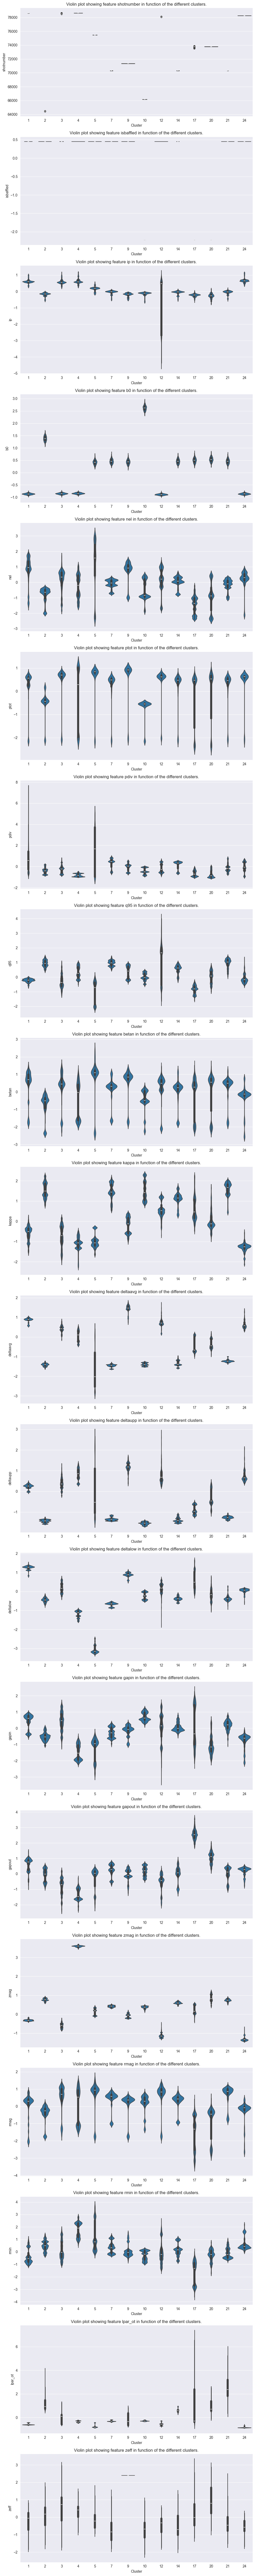

In [53]:
# Number of features to plot
num_features = interesting_clusters_df.shape[1] - 1  # excluding the cluster label column

# Create a figure with subplots
fig, axes = plt.subplots(nrows=num_features, figsize=(10, num_features * 5))

# Loop through each feature and create a violin plot
for i, col in enumerate(interesting_clusters_df.columns[:-1]):  # excluding the cluster label column
    sns.violinplot(x='Cluster', y=col, data=interesting_clusters_df, ax=axes[i]).set(title=f'Violin plot showing feature {col} in function of the different clusters.')

plt.tight_layout()
plt.show()


Let's also find where features values are significantly different between the two groups :

In [54]:
qce_h_clusters = [9,12,24]
non_qce_h_clusters = list(set(desired_clusters) - set(qce_h_clusters))

non_qce_h_data_points = interesting_clusters_df[interesting_clusters_df['Cluster'].isin(non_qce_h_clusters)].drop(columns=['shotnumber'])

qce_h_data_points = interesting_clusters_df[interesting_clusters_df['Cluster'].isin(qce_h_clusters)].drop(columns=['shotnumber'])

In [55]:
feature_significant_difference = []
for feature in column_names[2:-1]:

    _, p_value = stats.mannwhitneyu(non_qce_h_data_points[feature], qce_h_data_points[feature])
    if p_value < 0.05:
        feature_significant_difference.append(feature)
print(f"Between non qce-h oriented clusters and qce-h oriented clusters: Mann-Whitney U Test displays a statistical difference at 95% confidence for {len(feature_significant_difference)} features: {feature_significant_difference} \n")

Between non qce-h oriented clusters and qce-h oriented clusters: Mann-Whitney U Test displays a statistical difference at 95% confidence for 18 features: ['isbaffled', 'ip', 'b0', 'nel', 'ptot', 'pdiv', 'q95', 'betan', 'deltaavg', 'deltaupp', 'deltalow', 'gapin', 'gapout', 'zmag', 'rmag', 'rmin', 'lpar_ot', 'zeff'] 


# Analysis

From the above Violin plots per cluster, we can emit the hypothesis that the distinctive values of clusters are the reason shots are grouped within it:

**Cluster 4**, has a clearly distinctive `zmag` value of 3.5 for the median compared to the other clusters for a mean value between -1 and 1.

**Cluster 5**, has a  `deltalow` median value below -3 compared to the other clusters for a median value above -2.

**Cluster 9**, which exhibits many datapoints in QCE-H mode, has a uniform `zeff` of ~2.5 for the median, hence might be what distinguish it.

**Cluster 12**, has a low `zmag` below -1 for the median, as well as **Cluster 24** hence indicating some corelation towards the QCE-H state

**Cluster 17** displays the highest value of `gappout` of ~2.5 median, while most other cluster shows values below 2

Other clusters, does not exhibit direct and visible patterns. To observe them considering multiple at a time might be helpful. 
For example, as a result of clusters 12, 24 and 9, it would be valuable to verify the correlation between `zeff` and `rmag`.



However, we can also see that DBSCAN is limited in its range of data interpretation as since our analysis limited by the continuity of our data whihc does not consider **time wise history**

**For this purpose, we therefore shift in accordance with the lab to supervised learning in order to evaluate this timewise dependency thanks to either the long-short term memory neural network (LSTM) or recurrent neural network (RNN).**


# Completion purposes - Kmeans:

For completion purposes of the clustering analysis, we discuss below why the usage of the Kmean algorithm is not suited here : 

Theoretically, 
- K-means assumes that clusters are spherical and homogenous in size and variance. This assumption does not hold true for time-series data, where clusters can have different snake like shapes as seen above.
- K-means does not take into account the temporal or continuous dependencies inherent in time-series data.

In fact we can demonstrate concretely why the K-mean algorithm is not a good fit for this problem : 

In [56]:
complete_X,_, _ = get_training_data(include_time = False, include_shotnumber = False, shot_indices = list(range(60)))


In [57]:
%%capture
# Compute the sum of squared distances for different numbers of clusters
sse = []
for k in range(1, 11):  # Adjust the range as needed
    kmeans = KMeans(n_clusters=k, random_state=0).fit(complete_X)
    sse.append(kmeans.inertia_)


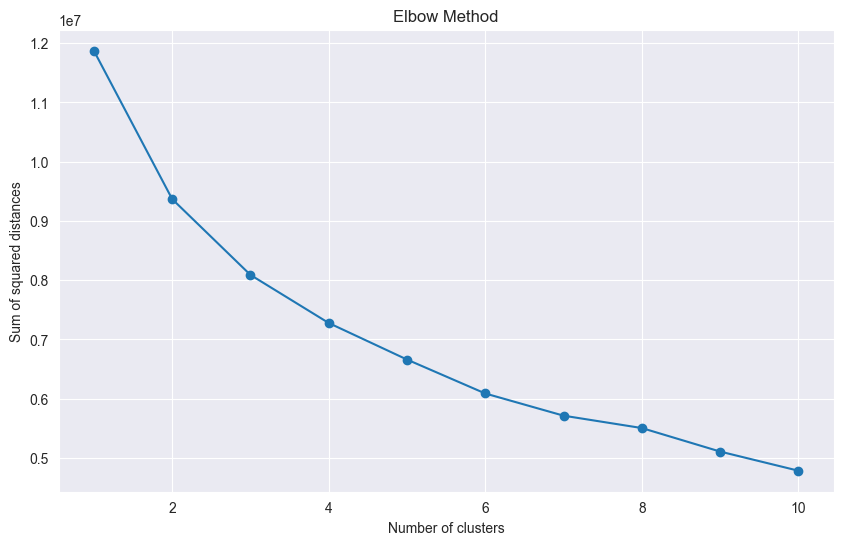

In [58]:
# Plot SSE against the number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')  # Adjust the range as needed
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.show()

As the elbow is non-apparent and silhouette score takes too much time to compute, we fine tune the K parameter manually thanks to PCA visualization, this is already an indicator of limitations within the K mean analysis.

 To compare Kmeans more accurately to DBSCAN, we will use the dimensionality reduction computed above through UMAP for clustering.
 
The best K seems to be 4 according to the PCA visualization:

In [59]:
%%capture
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit_predict(complete_X)

In [60]:
pca = PCA(n_components=2)  # for 2D visualization
pca_result = pca.fit_transform(complete_X)

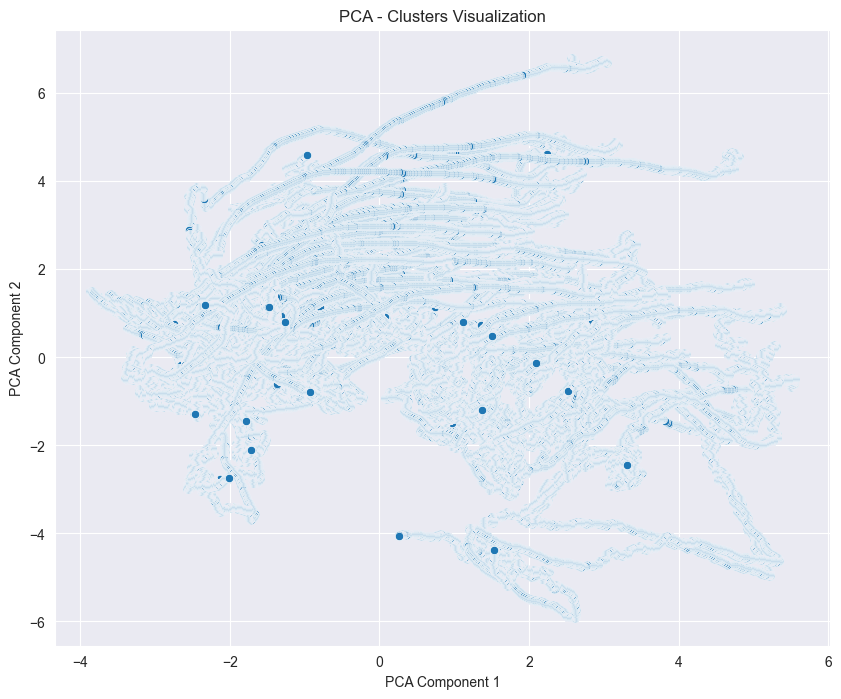

In [61]:

plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1])

plt.title('PCA - Clusters Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

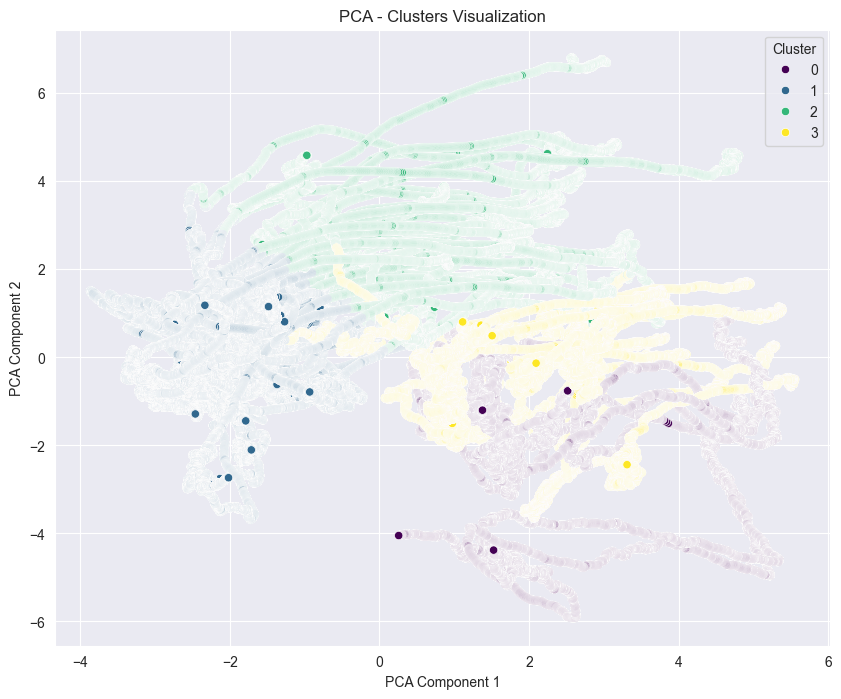

In [62]:

plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=clusters, palette="viridis")

plt.title('PCA - Clusters Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', loc='best')
plt.show()

The Kmeans clearly fails to map the evident clusters shown by the PCA. despite the helping UMAP, shots are not regrouped hence continuity of the data due to its timewise evolution is not considered.
This demonstrates why Kmeans is not appropriate here.


# Clustering Conclusion
Our clustering analyses were not very fruitful as we showed that our data was not adapted to Clustering. However, one interesting insight did come out of it! We saw that with DBSCAN our shots were clustered in groups. As such, we know that when training a prediction model, we must make sure that our training data represents all these clusters!

Note however that DBSCAN has one issue, it clusters shots only if they cross each other. But we want to consider shots as similar when they are almost parallel and have similar orientation! We define a distance metric between two shots. It is computed as the sum of euclidean distances between pairs of points that occured at the same timestep. As such, you may have two perfectly overlapping shots but going in opposite directions, and it will have a high distance. This is exactly what we want to achieve!

In [63]:
X, y, column_names = get_training_data(include_time = False, include_shotnumber = True, shot_indices = list(range(60)))
X.shape

(624858, 20)

We now have a normalized (important for the distance to be weighted the same for all features) array containing all the shots. And the first column corresponds to the shot numbers, so we can split X into a list of the normalized time series.

In [64]:
shot_number_col = X[:,0]
shot_numbers = np.unique(shot_number_col)
shot_numbers

array([61056., 61057., 64438., 64467., 64469., 64495., 64950., 66166.,
       66169., 70302., 70305., 70306., 70310., 70311., 70313., 70654.,
       70656., 70657., 71344., 71345., 71351., 73532., 73784., 73785.,
       73786., 73838., 73846., 75461., 75464., 78058., 78061., 78064.,
       78069., 78089., 78090., 78091., 78104., 78260., 78261., 78262.,
       78368., 78382., 78510., 78512., 78518., 78521., 78524., 78597.,
       78598., 78600., 78601., 78602., 78603., 78604., 78606., 78608.,
       78611., 78637., 78639., 78656.])

In [65]:
# Split the array based on unique values in the first column
list_shots = [(shot_number, X[X[:, 0] == shot_number][:,1:]) for shot_number in shot_numbers]
len(list_shots)

60

In [66]:
list_shots[0][1].shape

(9371, 19)

In [67]:
def compute_distance_pair_shots(np_shot1, np_shot2):
    min_rows = min(np_shot1.shape[0], np_shot2.shape[0])
    
    truncated_shot1 = np_shot1[:min_rows,:]
    truncated_shot2 = np_shot2[:min_rows,:]
    
    euclidean_distance_rows = np.sqrt(np.sum((truncated_shot1 - truncated_shot2)**2, axis = 1))
    shot_distance = np.sum(euclidean_distance_rows)
    
    return shot_distance
    

In [68]:
compute_distance_pair_shots(list_shots[0][1], list_shots[4][1])

52939.38846862117

In [69]:


shot_distances = []
for shot_number1, shot1 in list_shots:
    shot1_distances = []
    for shot_number2, shot2 in list_shots:
        shot1_distances.append(compute_distance_pair_shots(shot1, shot2))
        
    shot_distances.append(shot1_distances)
    
np_shot_distances = np.array(shot_distances)
np_shot_distances.shape

(60, 60)

In [70]:
print("max distance:", np_shot_distances.max())
print("min distance (not with itself):", np_shot_distances[np_shot_distances != 0].min())

max distance: 111195.06192942416
min distance (not with itself): 5236.837865477843


In [71]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

def cluster_points(distance_matrix, threshold_distance):
    # Convert the distance matrix to condensed form
    condensed_distance = squareform(distance_matrix)

    # Perform hierarchical clustering
    linkage_matrix = linkage(condensed_distance, method='average')

    # Cut the dendrogram to form flat clusters based on the threshold distance
    clusters = fcluster(linkage_matrix, t=threshold_distance, criterion='distance')

    # Group point indices into clusters
    clustered_points = {}
    shot_num_to_cluster = {}
    for i, cluster_id in enumerate(clusters):
        if cluster_id not in clustered_points:
            clustered_points[cluster_id] = []
        clustered_points[cluster_id].append(shot_numbers[i-1])
        shot_num_to_cluster[shot_numbers[i-1]] = cluster_id

    return clustered_points, shot_num_to_cluster

In [72]:
threshold_distance = 50000

# Perform clustering
result_clusters, shot_num_to_cluster = cluster_points(np_shot_distances, threshold_distance)

# Display the clusters
for cluster_id, point_indices in result_clusters.items():
    print(f"Cluster {cluster_id}: {point_indices}")

Cluster 5: [78656.0, 64469.0, 64495.0, 70313.0, 70654.0, 70656.0, 70657.0, 71344.0, 71345.0, 78058.0, 78061.0, 78064.0, 78069.0, 78089.0, 78090.0, 78091.0, 78260.0, 78261.0, 78368.0, 78382.0, 78510.0, 78512.0, 78518.0, 78521.0, 78524.0, 78597.0, 78598.0, 78600.0, 78601.0, 78602.0, 78603.0, 78604.0, 78606.0, 78608.0, 78611.0, 78637.0, 78639.0]
Cluster 4: [61056.0, 61057.0, 64438.0, 64467.0, 64950.0, 66166.0, 66169.0, 70302.0, 70305.0, 70306.0, 70310.0, 70311.0]
Cluster 3: [71351.0, 73532.0, 73784.0, 73785.0, 73786.0, 73838.0]
Cluster 1: [73846.0, 75461.0]
Cluster 6: [75464.0]
Cluster 2: [78104.0]
Cluster 7: [78262.0]


Now we want to visualize these clusters! So we need to map the shot_numbers to the associated clusters

In [73]:
cluster_labels = np.copy(shot_number_col)
for k, v in shot_num_to_cluster.items(): 
    cluster_labels[cluster_labels==k] = v

In [74]:
components = perform_pca(X[:,1:], n_components = 3) # we discard the shotnumber

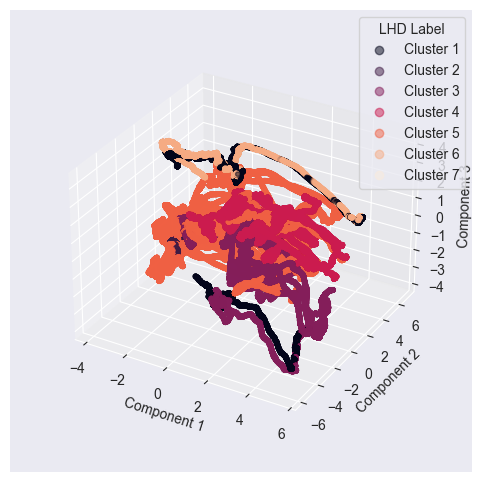

In [75]:
cluster_names = [f"Cluster {i+1}" for i in range(len(result_clusters))]
draw_reduced_space(components, cluster_labels, n_components=3, legend_labels = cluster_names, legend_title = "LHD Label", title='')

Now, In order to compare our supervised approach, let's define a baseline :

## Baseline 

Let's first retrieve the data to do the classifications.

In [9]:
# This normalizes the X values.
X_train, y_train, column_names, scaler = get_train_data_and_scaler(include_time = False, include_shotnumber = False, shot_indices = list(range(50)))
X_test, y_test, _ = get_test_data(include_time = False, include_shotnumber = False,scaler=scaler, shot_indices = list(range(51,60)))

In [10]:
X_tensor_train = torch.tensor(X_train, dtype=torch.float32)
y_tensor_train = torch.tensor((y_train - 1).astype(int), dtype=torch.long)

X_tensor_test = torch.tensor(X_test, dtype=torch.float32)
y_tensor_test = torch.tensor((y_test - 1).astype(int), dtype=torch.long)

### SOFTMAX classification

In [11]:
class LogisticRegression(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(in_dim, out_dim)
    
    def forward(self, x):
        return self.linear(x)
    

Baseline's needed parameters

In [12]:
input_dim = X_train.shape[1]  # Number of input features
output_dim = 3 # Number of output classes (binary classification)

model = LogisticRegression(input_dim, output_dim)

criterion = nn.CrossEntropyLoss()
num_epochs = 1000
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [13]:
train_losses = []
test_losses = []  
train_accuracies = []
test_accuracies = []
train_f1_scores = []
test_f1_scores = []

#### Metrics functions

In [41]:

def multi_confusion_matrix(y_predicted, y_expected, display_matrix=False):
    """
    Function constructing a multiclass confusion matrix
    
    :param y_predicted: pd.Series containing the predicted labels
    :param y_expected: pd.Series containing the expected labels
    :param display_matrix: bool if true shows the confusion matrix
    :return: pd.Dataframe containing the multiclass confusion matrix 
    with columns as true labels and rows are predicted labels
    """
    predicted_labels = y_predicted.unique()
    expected_labels = y_expected.unique()
    
    mtrx = pd.DataFrame(0, columns=expected_labels, index=expected_labels)
    
    for expected_label in expected_labels:
        for predicted_label in predicted_labels:
            count = sum((y_expected == expected_label) & (y_predicted == predicted_label))
            mtrx.at[predicted_label, expected_label] = count
    if display_matrix:
        display(mtrx)
    return mtrx

def diag(matrix):
    """
    Function retrieving the true values of a confusion matrix
    
    :param matrix: confusion matrix
    :return: list of all the diagonal values
    """
    if len(matrix.index) <= len(matrix.columns):
        zipped = zip(matrix.index, matrix.columns[:len(matrix.index)])
    else:
        zipped = zip(matrix.index[:len(matrix.columns)], matrix.columns)
    
    diag = []
    for idx,col in zipped:
        diag.append(matrix.at[idx,col])
    return diag

def multi_accuracy(matrix):
    """
    Function computing the accuracy associated with a confusion matrix
    :param matrix: confusion matrix
    :return: precision score
    """
    t = sum(diag(matrix))
    all = matrix.sum().sum()
    return t / all
    
def multi_precision(matrix):
    """
    Function computing the precision associated with a confusion matrix
    :param matrix: confusion matrix
    :return: precision score
    """
    tp = diag(matrix)
    pred_p = matrix.sum(axis=1)
    return (tp / pred_p).fillna(0)
def multi_recall(matrix):
    """
    Function computing the recall associated with a confusion matrix
    :param matrix: confusion matrix
    :return: recall score
    """
    tp = diag(matrix)
    acutal_p = matrix.sum(axis=0)
    return (tp / acutal_p).fillna(0)

def multi_f1_score(matrix):
    """
    Function computing the F1-score associated with a confusion matrix
    :param matrix: confusion matrix
    :return: F1-score
    """
    recall = multi_recall(matrix)
    precision = multi_precision(matrix)
    
    multiplied = recall.multiply(precision)
    summed =recall + precision
    return (2 * multiplied / summed).fillna(0)

Train the baseline :

In [15]:
for epoch in range(num_epochs):
    # Forward pass on training data
    outputs_train = model(X_tensor_train)
    loss_train = criterion(outputs_train, y_tensor_train)
    train_losses.append(loss_train.item()) 

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss_train.item():.4f}')

    # Evaluate on test data
    model.eval()
    with torch.no_grad():
        outputs_train = model(X_tensor_train)
        y_predicted = torch.argmax(outputs_train, dim=1)
        y_predicted = pd.Series(y_predicted)
        mtrx_train = multi_confusion_matrix(y_predicted + 1, y_train)
        train_f1_scores.append(multi_f1_score(mtrx_train))
        train_accuracies.append(multi_accuracy(mtrx_train))
        
        outputs_test = model(X_tensor_test)
        y_predicted = torch.argmax(outputs_test, dim=1)
        
        y_predicted = pd.Series(y_predicted)
        mtrx_test = multi_confusion_matrix(y_predicted + 1, y_test)
        test_f1_scores.append(multi_f1_score(mtrx_test))
        test_accuracies.append(multi_accuracy(mtrx_test))
        
    model.train()

Epoch [100/1000], Training Loss: 0.4057
Epoch [200/1000], Training Loss: 0.3782
Epoch [300/1000], Training Loss: 0.3681
Epoch [400/1000], Training Loss: 0.3629
Epoch [500/1000], Training Loss: 0.3596
Epoch [600/1000], Training Loss: 0.3572
Epoch [700/1000], Training Loss: 0.3553
Epoch [800/1000], Training Loss: 0.3537
Epoch [900/1000], Training Loss: 0.3525
Epoch [1000/1000], Training Loss: 0.3514


Now let us display the base line's evolution :

In [16]:
def sort_score_per_label(scores):
    l_mode_scores = []
    qce_h_mode_scores = []
    elmy_mode_scores = []
    
    for score in scores:
        l_mode_scores.append(score.loc[1])
        qce_h_mode_scores.append(score.loc[2])
        elmy_mode_scores.append(score.loc[3])
    return l_mode_scores, qce_h_mode_scores, elmy_mode_scores


In [17]:
l_mode_scores_tr, qce_h_mode_scores_tr, elmy_mode_scores_tr = sort_score_per_label(train_f1_scores)
l_mode_scores_ts, qce_h_mode_scores_ts, elmy_mode_scores_ts = sort_score_per_label(test_f1_scores)

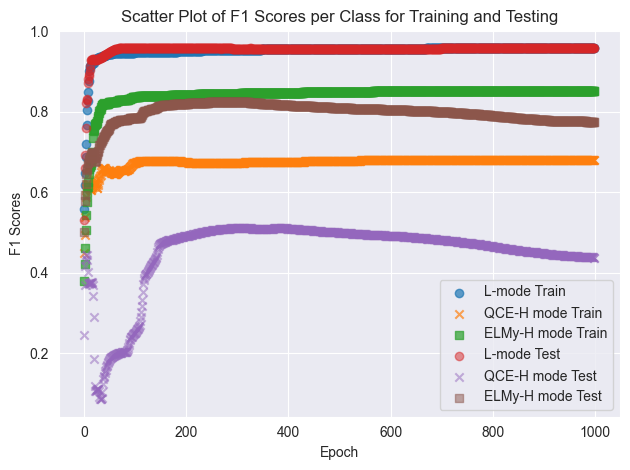

In [18]:
x = np.arange(len(l_mode_scores_tr))

plt.scatter(x, l_mode_scores_tr, label='L-mode Train', marker='o', alpha=0.7)
plt.scatter(x, qce_h_mode_scores_tr, label='QCE-H mode Train', marker='x', alpha=0.7)
plt.scatter(x, elmy_mode_scores_tr, label='ELMy-H mode Train', marker='s', alpha=0.7)


plt.scatter(x, l_mode_scores_ts, label='L-mode Test', marker='o', alpha=0.5)
plt.scatter(x, qce_h_mode_scores_ts, label='QCE-H mode Test', marker='x', alpha=0.5)
plt.scatter(x, elmy_mode_scores_ts, label='ELMy-H mode Test', marker='s', alpha=0.5)


plt.xlabel('Epoch')
plt.ylabel('F1 Scores')
plt.title('Scatter Plot of F1 Scores per Class for Training and Testing')

plt.legend()


plt.grid(True)
plt.tight_layout()
plt.show()

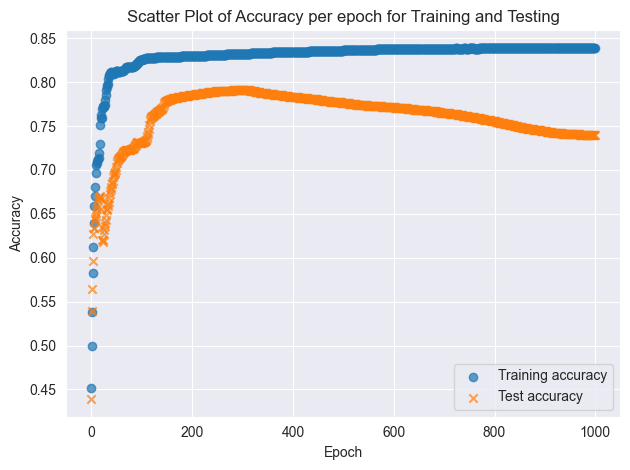

In [19]:
x = np.arange(len(train_accuracies))

plt.scatter(x, train_accuracies, label='Training accuracy', marker='o', alpha=0.7)
plt.scatter(x, test_accuracies, label='Test accuracy', marker='x', alpha=0.7)


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Scatter Plot of Accuracy per epoch for Training and Testing')

plt.legend()


plt.grid(True)
plt.tight_layout()
plt.show()

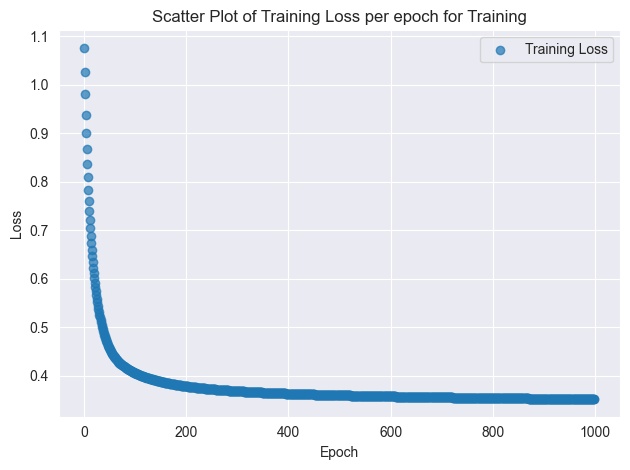

In [20]:
x = np.arange(len(train_losses))

plt.scatter(x, train_losses, label='Training Loss', marker='o', alpha=0.7)



plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Scatter Plot of Training Loss per epoch for Training')

plt.legend()


plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
test_f1_scores[-1].name = "Final F1 Score"
test_f1_scores[-1]

1.0    0.958451
3.0    0.775632
2.0    0.437810
Name: Final F1 Score, dtype: float64

The baseline to beat is consists of 0.95 for L-mode, 0.79 for ELMy-H mode and 0.46 for QCE-H mode

Now the RNN and LSTM models, but first some data preprocessing :

# LSTM & RNN, Data preprocessing & Retrieval

In [22]:
MAX_SHOT_LENGTH = 11001
output_size = 4
batch_size = 10
input_size = len(MACHINE_INPUTS)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [23]:
def pad_dataframe(data, to_length, columns=INPUTS):
    # Padd shot' samples with dummy values at the beginning if the shot is too short
    if to_length != None and data.shape[0] < to_length:
        df = pd.DataFrame(0, index=np.arange(to_length - data.shape[0]), columns=columns)
        data = pd.concat([df, data], axis=0, ignore_index=True)
    return data

In [26]:
save_dir

''

In [27]:
file_names = [f for f in os.listdir('./QCEH_data/') if f.endswith('.parquet')]
file_names.sort()

test_shot_names = {
    "TCV_DATAno70310.parquet",
    "TCV_DATAno70311.parquet",
    "TCV_DATAno73838.parquet",
    "TCV_DATAno78603.parquet",
    "TCV_DATAno78604.parquet",
    "TCV_DATAno78606.parquet",
    "TCV_DATAno78608.parquet",
    "TCV_DATAno78611.parquet",
    "TCV_DATAno78637.parquet",
    "TCV_DATAno78639.parquet"
}

train_filenames = []
test_filenames = []
for file in file_names:
  if file in test_shot_names:
    test_filenames.append('QCEH_data/'+file)
  else:
    train_filenames.append('QCEH_data/'+file)

print(train_filenames)
print(test_filenames)
print(len(train_filenames), len(test_filenames), len(train_filenames) + len(test_filenames))

['QCEH_data/TCV_DATAno61056.parquet', 'QCEH_data/TCV_DATAno61057.parquet', 'QCEH_data/TCV_DATAno64438.parquet', 'QCEH_data/TCV_DATAno64467.parquet', 'QCEH_data/TCV_DATAno64469.parquet', 'QCEH_data/TCV_DATAno64495.parquet', 'QCEH_data/TCV_DATAno64950.parquet', 'QCEH_data/TCV_DATAno66166.parquet', 'QCEH_data/TCV_DATAno66169.parquet', 'QCEH_data/TCV_DATAno70302.parquet', 'QCEH_data/TCV_DATAno70305.parquet', 'QCEH_data/TCV_DATAno70306.parquet', 'QCEH_data/TCV_DATAno70313.parquet', 'QCEH_data/TCV_DATAno70654.parquet', 'QCEH_data/TCV_DATAno70656.parquet', 'QCEH_data/TCV_DATAno70657.parquet', 'QCEH_data/TCV_DATAno71344.parquet', 'QCEH_data/TCV_DATAno71345.parquet', 'QCEH_data/TCV_DATAno71351.parquet', 'QCEH_data/TCV_DATAno73532.parquet', 'QCEH_data/TCV_DATAno73784.parquet', 'QCEH_data/TCV_DATAno73785.parquet', 'QCEH_data/TCV_DATAno73786.parquet', 'QCEH_data/TCV_DATAno73846.parquet', 'QCEH_data/TCV_DATAno75461.parquet', 'QCEH_data/TCV_DATAno75464.parquet', 'QCEH_data/TCV_DATAno78058.parquet', 

### Data reading functions

In [28]:
def read_data(file_names, expected_length=None):
    df_list = [
        pad_dataframe(
            pd.read_parquet(x).drop(columns=['alpha', 'H98y2calc'], errors='ignore'),
            expected_length
        )
        for x in file_names]
    df_list = pd.concat(df_list, ignore_index=True)
    df_list = df_list[MACHINE_INPUTS + LABEL]

    X = df_list.drop(["LHD_label"], axis=1)
    y = df_list["LHD_label"]

    return df_list, X, y


def analyse_data(file_names):
    _, X, y = read_data(file_names, MAX_SHOT_LENGTH)

    x_mean = np.mean(X, axis=0)
    x_std = np.std(X, axis=0)

    y_compared = np.arange(output_size)[:, np.newaxis] == np.array(y)
    labels_distribution = np.sum(y_compared, axis=1) / y.shape[0]

    return torch.tensor(x_mean, dtype=torch.float32), torch.tensor(x_std, dtype=torch.float32), torch.tensor(
        labels_distribution, dtype=torch.float32)


x_mean, x_std, labels_distribution = analyse_data(train_filenames)
print("labels distribution: ", labels_distribution)

torch.save(x_mean, "x_mean.pt")
torch.save(x_std, "x_std.pt")
torch.save(labels_distribution, "labels_distribution.pt")

labels distribution:  tensor([0.0360, 0.2290, 0.2247, 0.5103])


/var/folders/vq/vpp5gf_96v7f5w4frq2kpfn00000gn/T/ipykernel_9636/3692491505.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(x_mean, dtype=torch.float32), torch.tensor(x_std, dtype=torch.float32), torch.tensor(


### Dataset handler classes :

In [29]:
class QCEH_Dataset(Dataset):
  def __init__(self, file_names, sequence_length, mean, std, transform=None):
    self.samples = []
    self.labels = []

    for file_name in file_names:
      _, X, y = read_data([file_name], sequence_length)
      X = torch.tensor(X.values, dtype=torch.float32)
      y = torch.tensor(y.values, dtype=torch.float32)
      X_normalized = (X - torch.unsqueeze(mean, 0)) / torch.unsqueeze(std, 0)

      if transform:
        X_normalized = transform(X_normalized)

      self.samples.append(X_normalized.to(device))
      self.labels.append(y.to(device))

  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    return self.samples[idx], self.labels[idx]

In [30]:
class QCEH_Dataset_Downsampled(Dataset):
  def __init__(self, file_names, mean, std, step_size, sub_sequence_length, sequence_length, transform=None, record=False):
    self.step_size = step_size
    self.sequence_length = sequence_length
    self.sub_sequence_length = sub_sequence_length

    self.samples = []
    self.labels = []

    for file_name in file_names:
      _, X, y = read_data([file_name], sequence_length)
      X = torch.tensor(X.values, dtype=torch.float32)
      y = torch.tensor(y.values, dtype=torch.float32)
      X_normalized = (X - torch.unsqueeze(mean, 0)) / torch.unsqueeze(std, 0)

      if transform:
        X_normalized = transform(X_normalized)

      self.samples.append(X_normalized)
      self.labels.append(y)

    if record:
      self.record = torch.zeros((output_size), dtype=torch.float32)

  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    X = self.samples[idx]

    sub_sequence_id = random.randint(0, self.step_size - 1)
    sub_sequence_ids = torch.arange(0, self.sequence_length)
    sub_sequence_ids = sub_sequence_ids[
        sub_sequence_ids % self.step_size == sub_sequence_id
        ]
    sub_sequence_ids = sub_sequence_ids[:self.sub_sequence_length]

    samples = self.samples[idx][sub_sequence_ids,:]
    labels = self.labels[idx][sub_sequence_ids]

    if self.record != None:
      for i in range(output_size):
        self.record[i] += torch.sum(labels == i)

    samples = samples.to(device)
    labels = labels.to(device)

    return samples, labels

  def get_record(self):
    return self.record.clone().detach()

Instanciate the Data :

In [31]:
train_data = QCEH_Dataset(
    train_filenames,
    MAX_SHOT_LENGTH,
    x_mean,
    x_std
)

test_data = QCEH_Dataset(
    test_filenames,
    MAX_SHOT_LENGTH,
    x_mean,
    x_std
)

downsample_step = 11
downsample_sequence_size = math.floor(MAX_SHOT_LENGTH / downsample_step)
downsampled_training_data = QCEH_Dataset_Downsampled(
    train_filenames,
    x_mean,
    x_std,
    downsample_step,
    downsample_sequence_size,
    MAX_SHOT_LENGTH,
    record=True
)

downsampled_test_data = QCEH_Dataset_Downsampled(
    test_filenames,
    x_mean,
    x_std,
    downsample_step,
    downsample_sequence_size,
    MAX_SHOT_LENGTH,
    record=True
)

In [32]:
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
downsampled_train_dataloader = DataLoader(downsampled_training_data, batch_size=batch_size, shuffle=True)
downsampled_test_dataloader = DataLoader(downsampled_test_data, batch_size=batch_size, shuffle=True)

### RNN & LSTM Helper functions

In [33]:
def decode_output_to_states(output):
  # Convert predictions to probability of each class
  prob = F.softmax(output, dim=1).data
  # Taks the class with the highest probability score from the output
  output_states = torch.max(prob, dim=1)
  return output_states[1]

In [34]:
def run_model(model, output_size, dataloader, loss_fn, optimizer=None, display_matrix=False):
  loss_total = 0

  y_predicted = torch.empty((0,), dtype=torch.float32).to(device)
  y_labels = torch.empty((0,), dtype=torch.float32).to(device)

  for x, y in dataloader:
    if optimizer:
      optimizer.zero_grad()

    x = x.to(device)
    y = y.to(device)

    output, hidden = model(x)
    output_states = decode_output_to_states(output)

    loss = loss_fn(output, y.long().view(-1))

    if optimizer:
      loss.backward()
      optimizer.step()

    loss_total += loss

    # Records outputs for confusion matrix computation
    y_predicted = torch.cat([y_predicted, torch.reshape(output_states, (-1,))])
    y_labels = torch.cat([y_labels, torch.reshape(y, (-1,))])

  # Confusion matrix & f1 score
  matrix = multi_confusion_matrix(pd.Series(y_predicted.cpu()), pd.Series(y_labels.cpu()), display_matrix=display_matrix)
  multi_f1 = multi_f1_score(matrix)

  return loss_total.item(), matrix, multi_f1

In [35]:
def train_model(model, output_size, dataloader, optimizer, loss_fn, n_epochs):
  model.train()

  loss_history = []
  f1_scores = []
  for out in range(output_size):
    f1_scores.append([])

  # Training Run
  for epoch in range(0, n_epochs):
    loss, _, multi_f1 = run_model(model, output_size, train_dataloader, loss_fn,
                                  optimizer=optimizer, display_matrix=(epoch == n_epochs - 1))

    loss_history.append(loss)
    for out in range(output_size):
      f1_scores[out].append(multi_f1[out].item())

    if epoch == 0:
      print('Training... [', end='')
    if epoch%10 == 0:
      print('#', end='')
    if epoch == n_epochs - 1:
      print('] done!')
      print('Epoch: {}/{}.............'.format(epoch + 1, n_epochs), end=' ')
      print("Loss: {:.4f}".format(loss))
      for out in range(output_size):
        print("\t state {}: F1 score = {:.4f}".format(out, f1_scores[out][-1]))

  # Plot results
  fig, ax = plt.subplots(1, 1)
  ax.plot(loss_history, 'm', label="Loss")
  ax.set_xlabel("Epoch")
  ax.set_ylabel("Loss")
  ax2 = ax.twinx()
  ax2.set_ylabel('F1 score')
  for out in range(output_size):
    ax2.plot(f1_scores[out], label='F1 score state {}'.format(out))
  ax.legend(loc="upper left")
  ax2.legend(loc="upper right")
  plt.show()

In [36]:
def test_model(model, output_size, lossFn, test_dataloader):
  model.eval()

  loss, _, multi_f1 = run_model(model, output_size, test_dataloader, lossFn, display_matrix=True)

  print("Evaluating model on testing data:")
  print("Loss: {:.4f}".format(loss))
  for out in range(output_size):
    print("\t state {}: F1 score = {:.4f}".format(out, multi_f1[out]))

## RNN & LSTM Trainings

Define loss & epoch

In [37]:
cross_entropy = nn.CrossEntropyLoss(weight=labels_distribution.to(device))

#hyperparameters
n_epochs_rnn = 400
n_epochs_lstm = 400

### RNN

In [38]:
# create our RNN based network with an RNN followed by a linear layer
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, n_layers, drop_prob):
        super().__init__()

        self.hidden_dim = hidden_size
        self.n_layers = n_layers

        # Defining the layers
        # RNN Layer
        self.RNN = nn.RNN(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=n_layers,
                          nonlinearity='tanh',
                          batch_first=True,
                          dropout=drop_prob)
        # Dropout layer
        self.dropout = nn.Dropout(drop_prob)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
      batch_size = x.size(0)

      # Initializing hidden state for first input using method defined below
      hidden = self.init_hidden(batch_size)

      # Passing in the input and hidden state into the model and obtaining outputs
      out, hidden = self.RNN(x, hidden)

      # Passing trough the dropout layer
      out = self.dropout(out)

      # Reshaping the outputs such that it can be fit into the fully connected layer
      out = out.contiguous().view(-1, self.hidden_dim)
      out = self.fc(out)

      return out, hidden

    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim, dtype=torch.float32)
        hidden = hidden.to(device)
        return hidden

In [39]:
def train_RNN_model(input_size, output_size, num_layers, hidden_size, drop_prob, learning_rate, n_epochs, train_dataloader, loss_fn):
  print("---------------------------------------")
  print("Training RNN model with hyperparameters:")
  print("hidden_size = ", hidden_size)
  print("num_layers = ", num_layers)
  print("drop_prob = ", drop_prob)
  print("learning_rate = ", learning_rate)
  print("n_epochs = ", n_epochs)

  # Create our network instance, pick loss function and optimizer
  model = RNN(input_size, output_size, hidden_size, num_layers, drop_prob)
  model = model.to(device)

  # Define Loss, Optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Train model
  train_model(model, output_size, train_dataloader, optimizer, loss_fn, n_epochs)

  return model

In [42]:
for learning_rate_exp in range(-5, -1):
  learning_rate = 10 ** learning_rate_exp

  for num_layers_exp in range(0, 4):
    num_layers = 2 ** num_layers_exp

    for hidden_size_exp in range(4, 7):
      hidden_size = 2 ** hidden_size_exp

      for drop_prob in [0.2, 0.5, 0.7]:
        rnn_trained_model = train_RNN_model(input_size, output_size, num_layers, hidden_size,
                                      drop_prob, learning_rate, n_epochs_rnn, train_dataloader, cross_entropy)
        if num_layers == 1:
          break

        test_model(rnn_trained_model, output_size, cross_entropy, test_dataloader)

        model_name = "./rnn_10^{}_{}_{}_{:.1f}".format(learning_rate_exp, num_layers, hidden_size_exp, drop_prob)
        torch.save(rnn_trained_model.state_dict(), model_name)

        print(model_name, " is trained !")
        print("\n\n")

---------------------------------------
Training RNN model with hyperparameters:
hidden_size =  16
num_layers =  1
drop_prob =  0.2
learning_rate =  1e-05
n_epochs =  400


/Users/ericsaikali/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/tokamak-unsupervised/venv/lib/python3.9/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Training... [#

KeyboardInterrupt: 

### LSTM

In [43]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        super().__init__()

        # Defining some parameters
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        #Defining the layers
        # RNN Layer
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.lstm(x, hidden)
        out = out.contiguous().view(-1, self.hidden_dim)

        # Passing trough the dropout layer
        out = self.dropout(out)

        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = self.fc(out)

        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [44]:
def train_LSTM_model(input_size, output_size, hidden_size, num_layers, learning_rate, drop_prob, n_epochs, train_dataloader, loss_fn):
  print("---------------------------------------")
  print("Training LSTM model with hyperparameters:")
  print("hidden_size = ", hidden_size)
  print("num_layers = ", num_layers)
  print("learning_rate = ", learning_rate)
  print("drop_prob = ", drop_prob)
  print("n_epochs = ", n_epochs)

  # Create our network instance, pick loss function and optimizer
  model = LSTM(input_size, output_size, hidden_size, num_layers)
  model = model.to(device)

  # Define Loss, Optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Train model
  train_model(model, output_size, train_dataloader, optimizer, loss_fn, n_epochs)

  return model

In [45]:
for learning_rate_exp in range(-5, -1):
  learning_rate = 10 ** learning_rate_exp

  for num_layers_exp in range(1, 3):
    num_layers = 2 ** num_layers_exp

    for hidden_size_exp in range(5, 8):
      hidden_size = 2 ** hidden_size_exp

      for drop_prob in [0.2, 0.5, 0.7]:
        ltsm_trained_model = train_LSTM_model(input_size, output_size, hidden_size,
                                      num_layers, learning_rate, drop_prob,
                                      n_epochs_lstm, downsampled_train_dataloader, cross_entropy)

        test_model(ltsm_trained_model, output_size, cross_entropy, downsampled_test_dataloader)

        model_name = "./ltsm_10^{}_{}_{}_{:.1f}".format(learning_rate_exp, num_layers, hidden_size_exp, drop_prob)
        torch.save(ltsm_trained_model.state_dict(), model_name)

        print(model_name, " is trained !")
        print("\n\n")

---------------------------------------
Training LSTM model with hyperparameters:
hidden_size =  32
num_layers =  2
learning_rate =  1e-05
drop_prob =  0.2
n_epochs =  400
Training... [#

KeyboardInterrupt: 